In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

c:\Users\User\anaconda3\envs\python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Generate dataset

In [2]:
# generate data ramdomly
# given v0, theta (features)
np.random.seed(0)
v0 = np.random.uniform(low=1, high=100, size=1000) # 1-100
theta = np.random.uniform(low=1, high=90, size=1000) # 1-90

def max_height(v0, theta):
    theta = theta*np.pi/180 # 換算為弧度
    h = (v0**2) * np.sin(theta)**2 / (2*9.8)
    return h

def max_length(v0, theta):
    theta = theta*np.pi/180
    l = (v0**2) * np.sin(2*theta) / 9.8
    return l

# calculate true max_height, max_length (targets)
max_h = max_height(v0, theta) # 斜拋最大高度
max_l = max_length(v0, theta) # 斜拋最大距離

print('The largest value of max_height: ', + np.max(max_h))
print('The largest value of max_length: ', + np.max(max_l))


The largest value of max_height:  483.1959574895825
The largest value of max_length:  1003.7532305530486


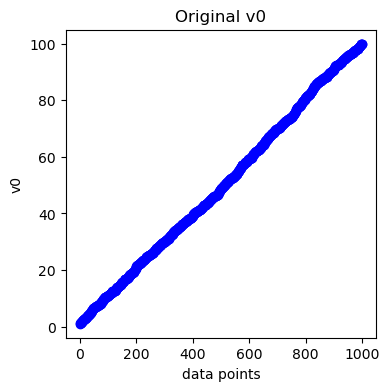

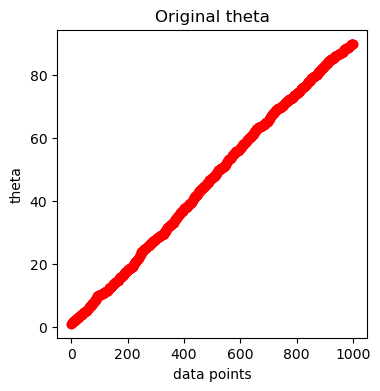

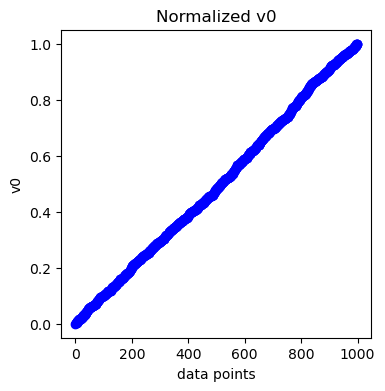

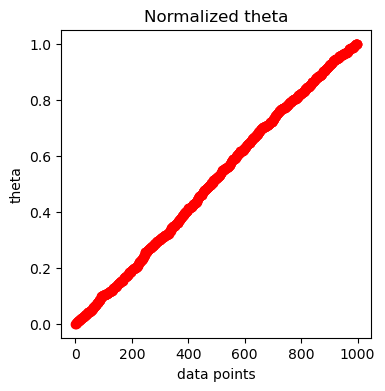

In [3]:
from sklearn.preprocessing import MinMaxScaler

# concate data
X = np.concatenate((v0.reshape(-1, 1), theta.reshape(-1, 1)), axis=1)
Y = np.concatenate((max_h.reshape(-1, 1), max_l.reshape(-1, 1)), axis=1)

plt.figure(figsize=(4, 4))
plt.plot(np.sort(X[:,0]), 'bo')
plt.title('Original v0')
plt.xlabel('data points')
plt.ylabel('v0')
plt.show()

plt.figure(figsize=(4, 4))
plt.plot(np.sort(X[:,1]), 'ro')
plt.title('Original theta')
plt.xlabel('data points')
plt.ylabel('theta')
plt.show()

# normalization
scaler_x = MinMaxScaler()
scaler_x.fit(X.reshape(-1, 2))
X = scaler_x.transform(X.reshape(-1, 2))

plt.figure(figsize=(4, 4))
plt.plot(np.sort(X[:,0]), 'bo')
plt.title('Normalized v0')
plt.xlabel('data points')
plt.ylabel('v0')
plt.show()

plt.figure(figsize=(4, 4))
plt.plot(np.sort(X[:,1]), 'ro')
plt.title('Normalized theta')
plt.xlabel('data points')
plt.ylabel('theta')
plt.show()

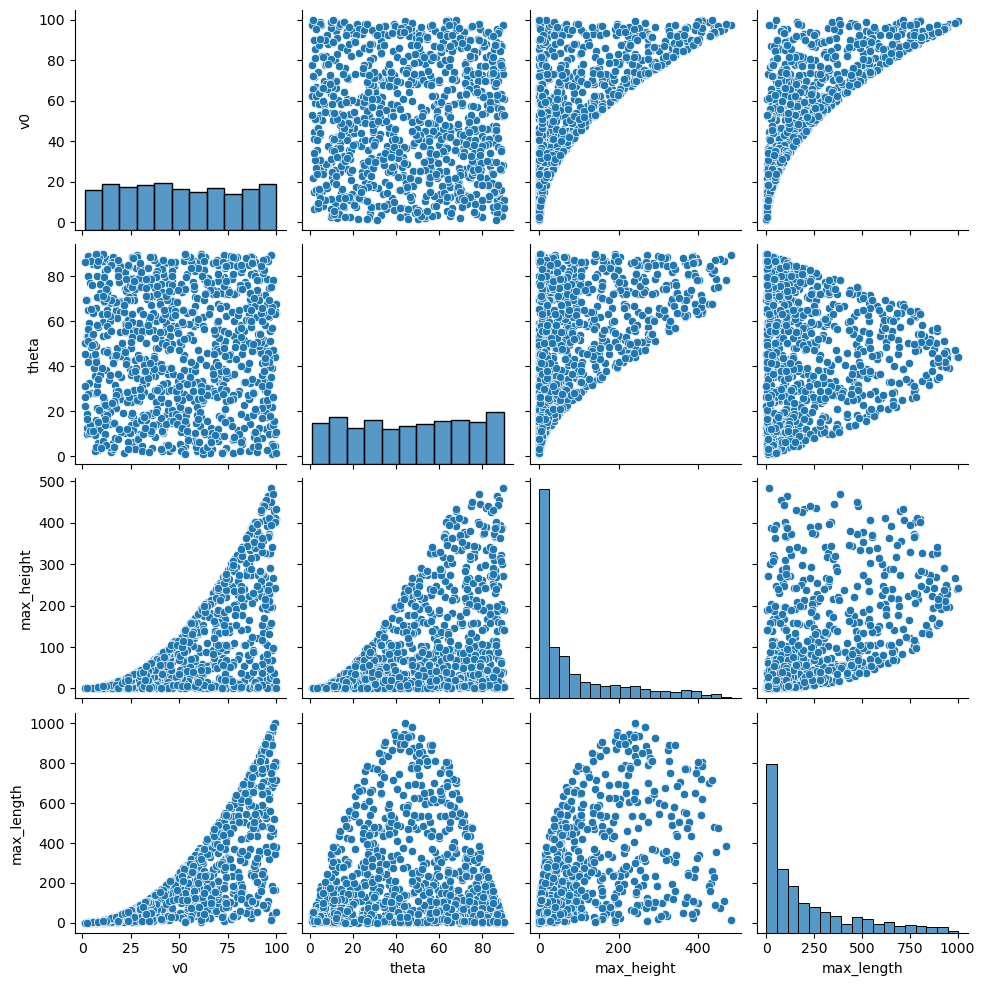

In [4]:
# pair plot
data = {'v0': v0, 'theta': theta, 'max_height': max_h, 'max_length': max_l}
data_f = pd.DataFrame(data)
sns.pairplot(data_f) # 可加上觀察敘述

<AxesSubplot:>

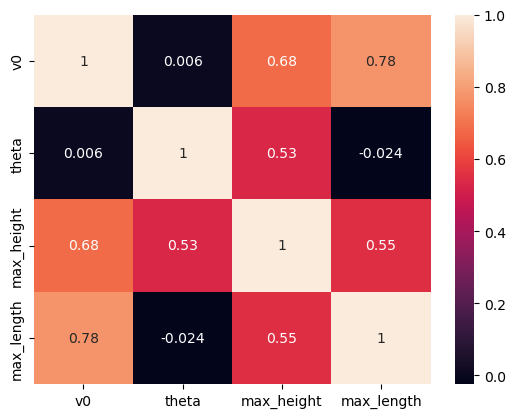

In [5]:
# correlation heatmap
sns.heatmap(data_f.corr(), annot=True)

# Functions and Classes

In [56]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchmetrics.functional import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold
import time
from torchsummary import summary

# dataset
class Projectile_Dataset(Dataset):
    def __init__(self, x, y, train=None, pred_target='max_height'):
        if pred_target == 'max_height':
            y = y[:, 0]
        elif pred_target == 'max_length':
            y = y[:, 1]

        if train != None:
            # train test split
            x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0)
            if train==True:
                x = x_train
                y = y_train
            else:
                x = x_test
                y = y_test
        
        # normalization
        scaler_x = MinMaxScaler()
        scaler_x.fit(x)
        x = scaler_x.transform(x)

        self.x = torch.from_numpy(x).type(torch.FloatTensor)
        self.y = torch.from_numpy(y).type(torch.FloatTensor) # n_samples, 1
        self.n_samples = x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples


# models
class MaxH_DNN(nn.Module):
    def __init__(self, activation_func='LeakyReLU'):
        super(MaxH_DNN, self).__init__()
        # 大約3層 改深度試看看
        if activation_func == 'ReLU':
            self.act = nn.ReLU()
        elif activation_func == 'LeakyReLU':
            self.act = nn.LeakyReLU()
        elif activation_func == 'Mish':
            self.act = nn.Mish()
        elif activation_func == 'Sigmoid':
            self.act = nn.Sigmoid()
        elif activation_func == 'Tanh':
            self.act = nn.Tanh()
        # self.layer1 = nn.Sequential(nn.Linear(2, 16), act)
        # self.layer2 = nn.Sequential(nn.Linear(16, 128), act)
        # self.layer3 = nn.Sequential(nn.Linear(128, 64), act)
        # self.layer4 = nn.Sequential(nn.Linear(64, 32), act)
        # self.layer5 = nn.Sequential(nn.Linear(32, 8), act)
        # self.layer6 = nn.Linear(8, 1)

        self.layer1 = nn.Linear(2, 16)
        self.layer2 = nn.Linear(16, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 32)
        self.layer5 = nn.Linear(32, 8)
        self.layer6 = nn.Linear(8, 1)

        # self.layer1 = nn.Linear(2, 3)
        # self.layer2 = nn.Linear(3, 4)
        # self.layer3 = nn.Linear(4, 5)
        # self.layer4 = nn.Linear(5, 5)
        # self.layer5 = nn.Linear(5, 4)
        # self.layer6 = nn.Linear(4, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.act(x)
        x = self.layer2(x)
        x = self.act(x)
        x = self.layer3(x)
        x = self.act(x)
        x = self.layer4(x)
        x = self.act(x)
        x = self.layer5(x)
        x = self.act(x)
        x = self.layer6(x)
        return x

class MaxL_DNN(nn.Module):
    def __init__(self, activation_func='LeakyReLU'):
        super(MaxL_DNN, self).__init__()
        if activation_func == 'ReLU':
            self.act = nn.ReLU()
        elif activation_func == 'LeakyReLU':
            self.act = nn.LeakyReLU()
        elif activation_func == 'Mish':
            self.act = nn.Mish()
        elif activation_func == 'Sigmoid':
            self.act = nn.Sigmoid()
        elif activation_func == 'Tanh':
            self.act = nn.Tanh()
        # self.layer1 = nn.Sequential(nn.Linear(2, 16), act)
        # self.layer2 = nn.Sequential(nn.Linear(16, 128), act)
        # self.layer3 = nn.Sequential(nn.Linear(128, 256), act)
        # self.layer4 = nn.Sequential(nn.Linear(256, 128), act)
        # self.layer5 = nn.Sequential(nn.Linear(128, 64), act)
        # self.layer6 = nn.Sequential(nn.Linear(64, 16), act)
        # self.layer7 = nn.Linear(16, 1)
        self.layer1 = nn.Linear(2, 16)
        self.layer2 = nn.Linear(16, 128)
        self.layer3 = nn.Linear(128, 256)
        self.layer4 = nn.Linear(256, 128)
        self.layer5 = nn.Linear(128, 64)
        self.layer6 = nn.Linear(64, 16)
        self.layer7 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.act(x)
        x = self.layer2(x)
        x = self.act(x)
        x = self.layer3(x)
        x = self.act(x)
        x = self.layer4(x)
        x = self.act(x)
        x = self.layer5(x)
        x = self.act(x)
        x = self.layer6(x)
        x = self.act(x)
        x = self.layer7(x)
        return x


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='Checkpoints/checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            # self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def train_model(model, train_loader, test_loader, num_epochs=500, lr=1e-2, weight_decay=1e-5, T_max=10, eta_min=1e-5, patience=20):
    """
    num_epochs : epochs 數量
    lr : 初始學習速率
    weight_decay : 權重衰退係數
    T_max : 調整學習速率的週期
    eta_min : 最小學習速率
    patience : 測試集誤差經過此數目epochs的學習後仍沒有改善誤差, 則停止訓練
    """
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min) # 隨著學習調整 lr
    criterion = nn.MSELoss() # loss function

    start = time.time()

    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    n_total_steps = len(train_loader)

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=False)

    # 使用 gpu 運算
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('cuda is available')
    model.to(device)

    for epoch in range(num_epochs):

        ##### Training loop #####
        model.train() # prep model for training
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.view(-1, 1).to(device)

            # forward
            outputs = model(inputs)
            loss = torch.sqrt(criterion(outputs, targets))

            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            
        # update lr
        scheduler.step()

        ##### Validation loop #####
        model.eval() # prep model for evaluation
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.view(-1, 1).to(device)

            outputs = model(inputs)
            loss = torch.sqrt(criterion(outputs, targets))
            valid_losses.append(loss.item())
        
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        print(f'[Epoch {epoch+1}/{num_epochs}] train_loss: {train_loss:.2f}, valid_loss: {valid_loss:.2f}')

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        early_stopping(train_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('Checkpoints/checkpoint.pt'))
    
    end = time.time()
    print(f'Training is end. Total trainig time: {(end-start)/60:.1f} minutes')
    print(f'Best validation loss: {np.min(avg_valid_losses)}')

    return model, avg_train_losses, avg_valid_losses


def loss_plot(avg_train_losses, avg_test_losses):
    plt.figure()
    plt.plot(avg_train_losses, 'r-', label='train')
    plt.plot(avg_test_losses, 'b-', label='valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('recorded loss')
    plt.legend()
    plt.show()


def model_evaluate(model, train_loader, test_loader, pred_target='max_height'):
    """
    Using RMSE & r2 score as metrics
    """
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('cuda is available')

    model = model.to(device).eval() # evaluation mode
    train_rmse_lst = []
    test_rmse_lst = []
    train_mape_lst = []
    test_mape_lst = []
    train_true_lst, train_pred_lst = [], []
    test_true_lst, test_pred_lst = [], []

    if pred_target == 'max_height':
        xlim, ylim = 0, 600
    elif pred_target == 'max_length':
        xlim, ylim = 0, 1100

    fig, ax = plt.subplots(figsize=(6, 6))
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets
            outputs = model(inputs)

            mape_train = r2_score(outputs.view(-1), targets.view(-1).cuda())
            rmse_train = mean_squared_error(outputs.view(-1), targets.view(-1).cuda(), squared=False)
            
            train_rmse_lst.append(rmse_train.item())
            train_mape_lst.append(mape_train.item())
            train_true_lst.append(targets.tolist())
            train_pred_lst.append(outputs.tolist())

            # plot
            if i == 0:
                ax.plot(outputs.cpu(), targets, 'ro', markersize=5, label='train')
            else:
                ax.plot(outputs.cpu(), targets, 'ro', markersize=5)
        
        print(f'Training set|RMSE: {np.average(train_rmse_lst):.2f}, R2: {np.average(train_mape_lst)}')

        for i, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.to(device)
            targets = targets
            outputs = model(inputs)
            
            mape_test = r2_score(outputs.view(-1), targets.view(-1).cuda())
            rmse_test = mean_squared_error(outputs.view(-1), targets.view(-1).cuda(), squared=False)
            
            test_rmse_lst.append(rmse_test.item())
            test_mape_lst.append(mape_test.item())
            test_true_lst.append(targets.tolist())
            test_pred_lst.append(outputs.tolist())

            # plot
            if i == 0:
                ax.plot(outputs.cpu(), targets, 'bo', markersize=5, label='valid')
            else:
                ax.plot(outputs.cpu(), targets, 'bo', markersize=5)

        print(f'Testing set|RMSE: {np.average(test_rmse_lst):.2f}, R2: {np.average(test_mape_lst)}')

        ax.set_title(pred_target)
        ax.set_xlim(xlim, ylim)
        ax.set_ylim(xlim, ylim)
        ax.plot([xlim, ylim], [xlim, ylim], 'k--', linewidth=1.5)
        ax.set_xlabel('predicted')
        ax.set_ylabel('ground truth')
        ax.legend()
        plt.savefig('Figures/'+pred_target+'.png')
        plt.show()
    
    return np.ravel(test_true_lst), np.ravel(test_pred_lst)


# Model structure

In [47]:
print('MaxH_DNN')
maxh_model = MaxH_DNN(activation_func='Mish').cuda()
summary(maxh_model, (50, 2))

MaxH_DNN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 50, 3]               9
              Mish-2                [-1, 50, 3]               0
            Linear-3                [-1, 50, 4]              16
              Mish-4                [-1, 50, 4]               0
            Linear-5                [-1, 50, 5]              25
              Mish-6                [-1, 50, 5]               0
            Linear-7                [-1, 50, 5]              30
              Mish-8                [-1, 50, 5]               0
            Linear-9                [-1, 50, 4]              24
             Mish-10                [-1, 50, 4]               0
           Linear-11                [-1, 50, 1]               5
Total params: 109
Trainable params: 109
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward

In [5]:
print('MaxL_DNN')
maxl_model = MaxL_DNN(activation_func='Mish').cuda()
summary(maxl_model, (50, 2))

MaxL_DNN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 50, 16]              48
              Mish-2               [-1, 50, 16]               0
            Linear-3              [-1, 50, 128]           2,176
              Mish-4              [-1, 50, 128]               0
            Linear-5              [-1, 50, 256]          33,024
              Mish-6              [-1, 50, 256]               0
            Linear-7              [-1, 50, 128]          32,896
              Mish-8              [-1, 50, 128]               0
            Linear-9               [-1, 50, 64]           8,256
             Mish-10               [-1, 50, 64]               0
           Linear-11               [-1, 50, 16]           1,040
             Mish-12               [-1, 50, 16]               0
           Linear-13                [-1, 50, 1]              17
Total params: 77,457
Trainable

# 比較不同 activation function

ReLU
Fold 1
cuda is available
Early stopping
Training is end. Total trainig time: 0.4 minutes
Best validation loss: 1.9094661474227905


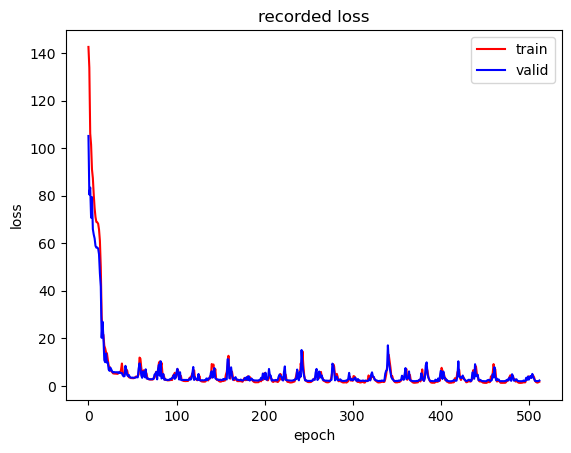

Fold 2
cuda is available
Training is end. Total trainig time: 0.7 minutes
Best validation loss: 1.075603425502777


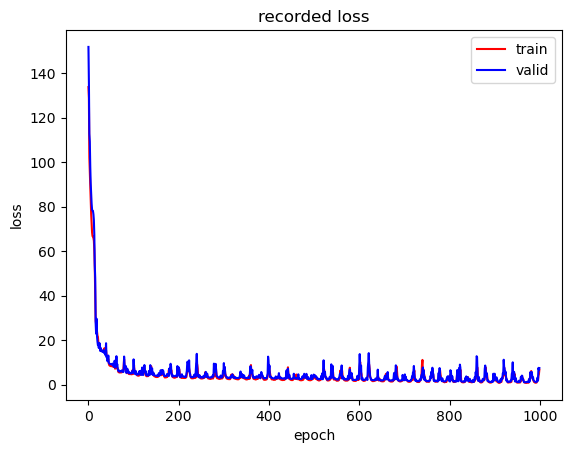

Fold 3
cuda is available
Early stopping
Training is end. Total trainig time: 0.1 minutes
Best validation loss: 19.489408493041992


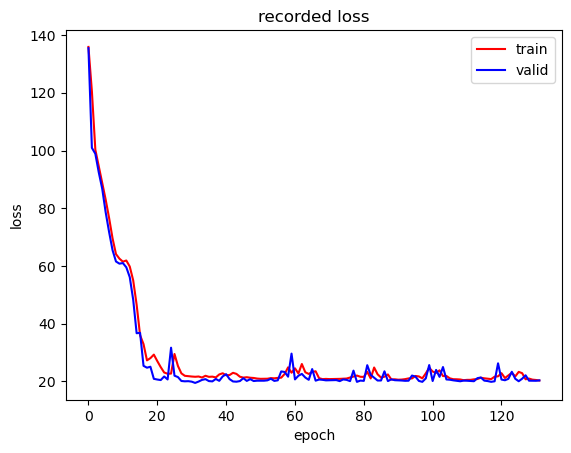

Fold 4
cuda is available
Early stopping
Training is end. Total trainig time: 0.4 minutes
Best validation loss: 1.2768945097923279


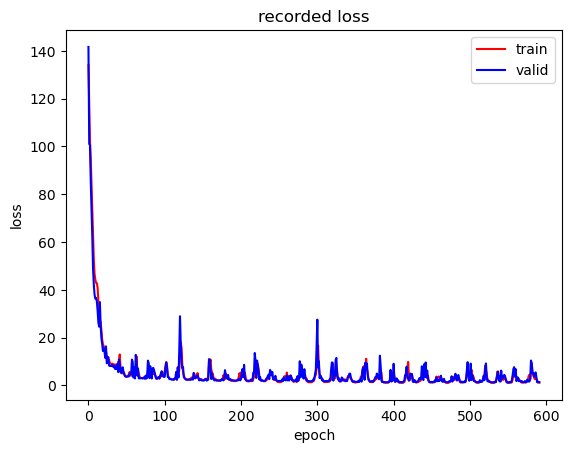

Fold 5
cuda is available
Early stopping
Training is end. Total trainig time: 0.3 minutes
Best validation loss: 1.0775124430656433


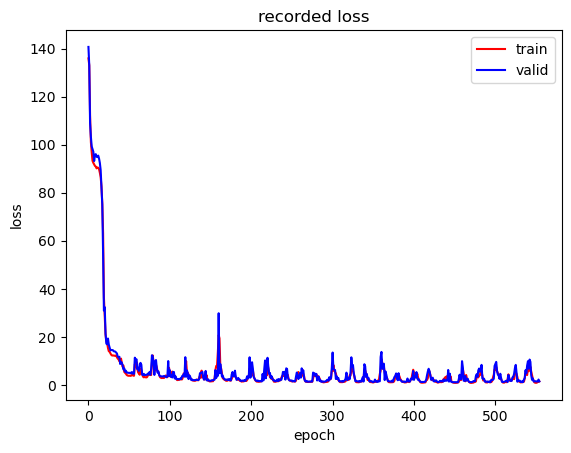

Averge RMSE performance: 4.965777003765107
LeakyReLU
Fold 1
cuda is available
Early stopping
Training is end. Total trainig time: 0.2 minutes
Best validation loss: 0.8379802107810974


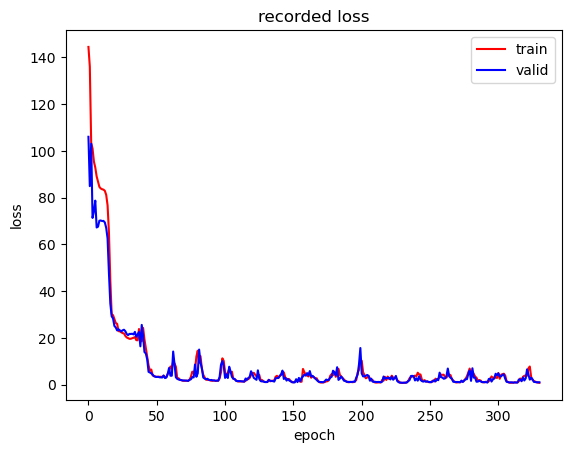

Fold 2
cuda is available
Early stopping
Training is end. Total trainig time: 0.2 minutes
Best validation loss: 0.9010236859321594


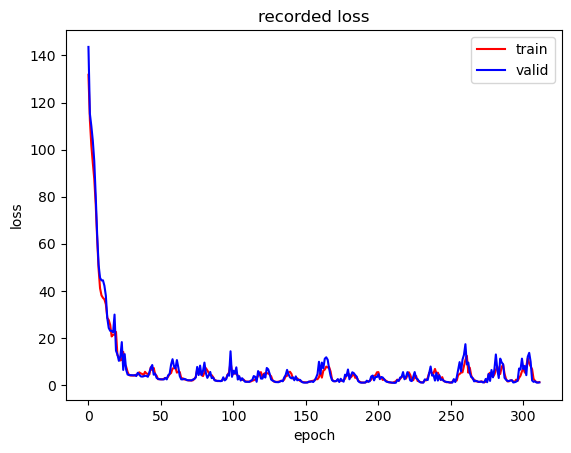

Fold 3
cuda is available
Early stopping
Training is end. Total trainig time: 0.3 minutes
Best validation loss: 1.184450775384903


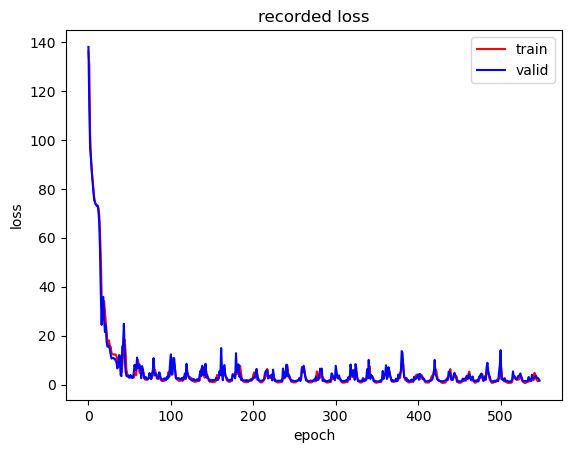

Fold 4
cuda is available
Early stopping
Training is end. Total trainig time: 0.4 minutes
Best validation loss: 0.673930436372757


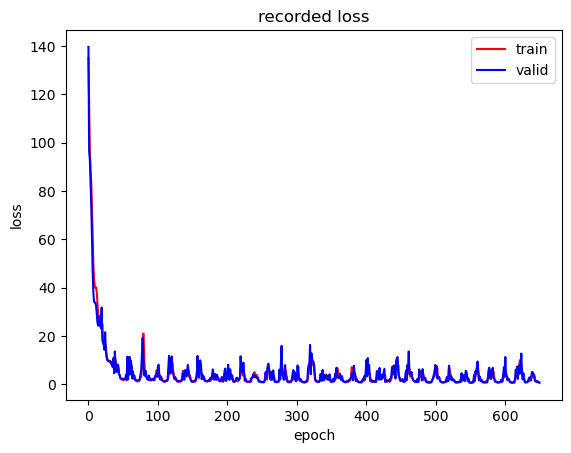

Fold 5
cuda is available
Early stopping
Training is end. Total trainig time: 0.3 minutes
Best validation loss: 0.9585622847080231


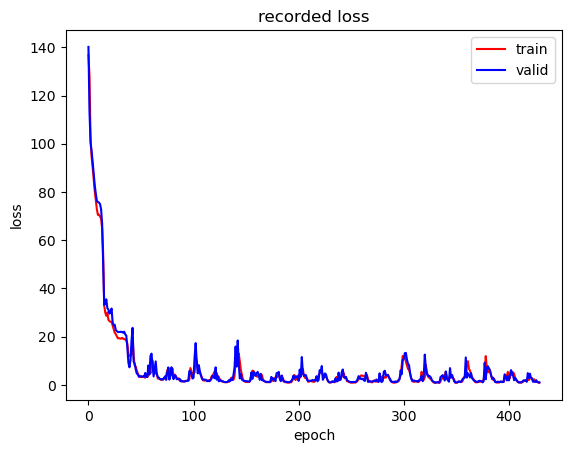

Averge RMSE performance: 0.9111894786357879
Sigmoid
Fold 1
cuda is available
Early stopping
Training is end. Total trainig time: 0.2 minutes
Best validation loss: 81.73777198791504


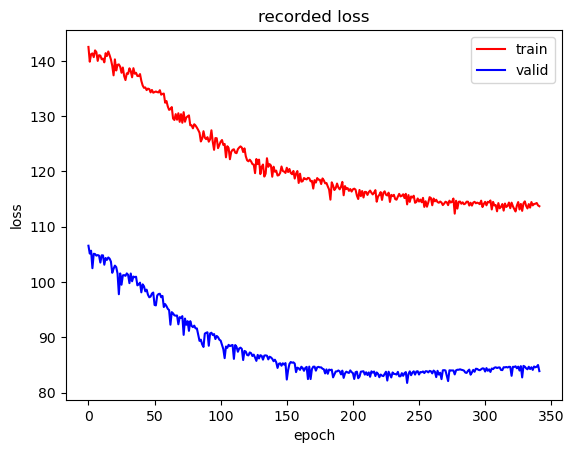

Fold 2
cuda is available
Early stopping
Training is end. Total trainig time: 0.1 minutes
Best validation loss: 117.78804206848145


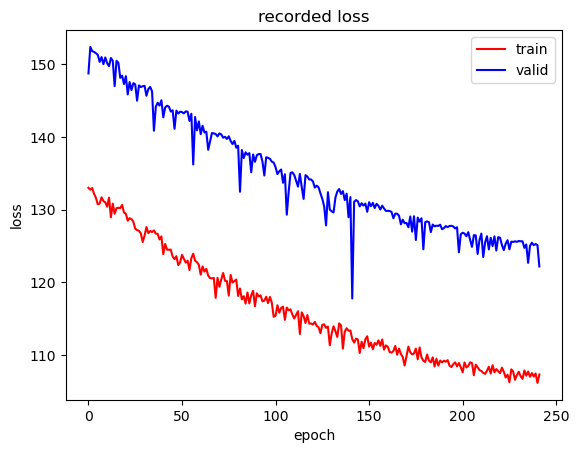

Fold 3
cuda is available
Early stopping
Training is end. Total trainig time: 0.2 minutes
Best validation loss: 108.94828414916992


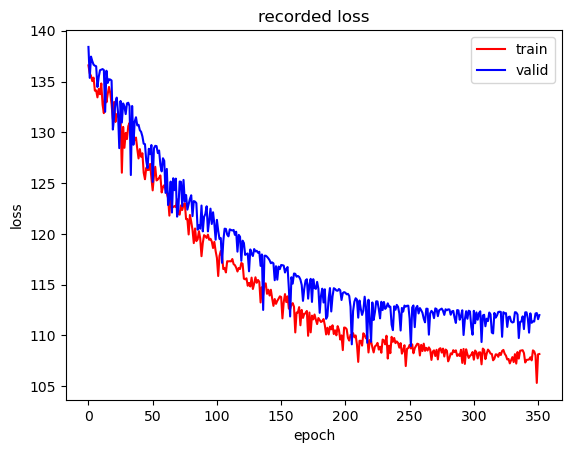

Fold 4
cuda is available
Early stopping
Training is end. Total trainig time: 0.3 minutes
Best validation loss: 109.69211959838867


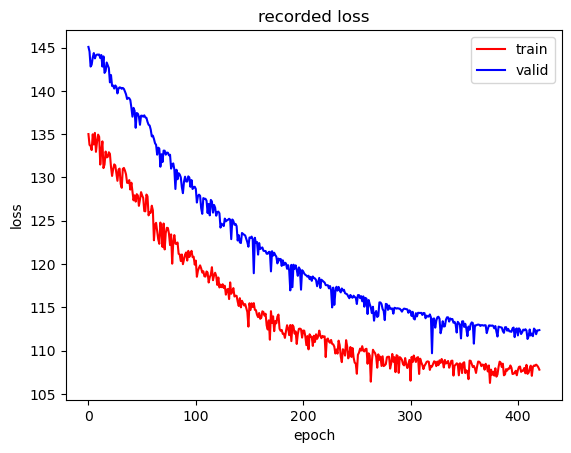

Fold 5
cuda is available
Early stopping
Training is end. Total trainig time: 0.2 minutes
Best validation loss: 108.88815689086914


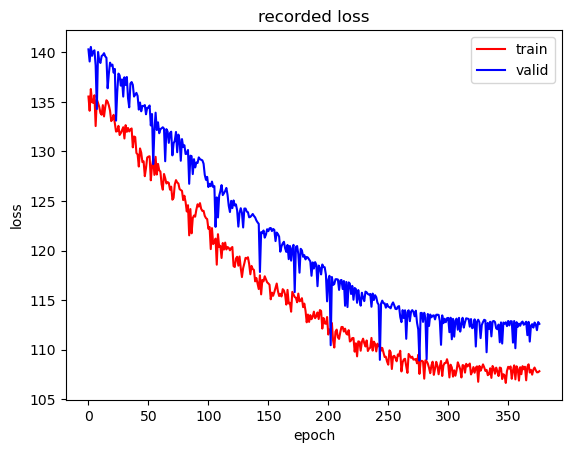

Averge RMSE performance: 105.41087493896484
Mish
Fold 1
cuda is available
Early stopping
Training is end. Total trainig time: 0.2 minutes
Best validation loss: 0.5182546973228455


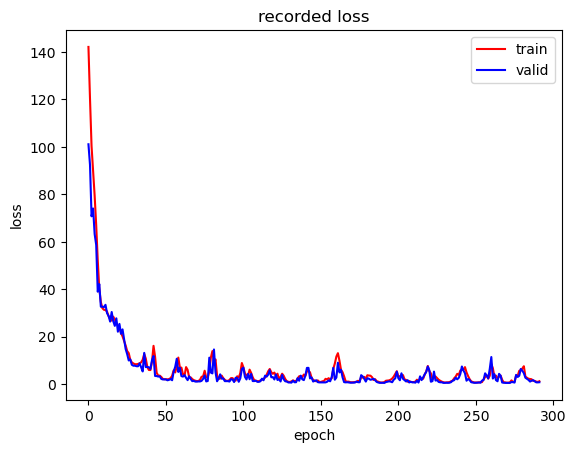

Fold 2
cuda is available
Early stopping
Training is end. Total trainig time: 0.3 minutes
Best validation loss: 0.730019748210907


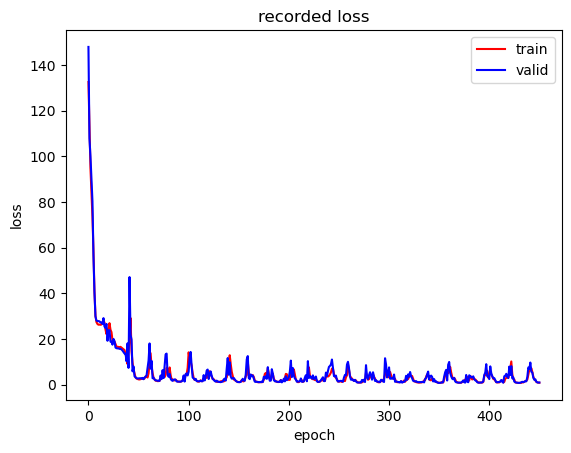

Fold 3
cuda is available
Early stopping
Training is end. Total trainig time: 0.2 minutes
Best validation loss: 1.0061608850955963


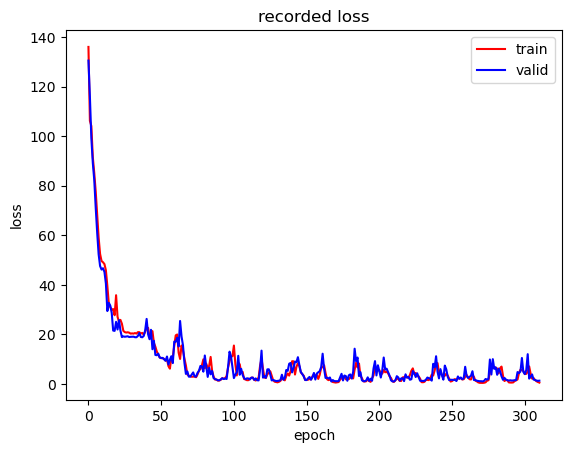

Fold 4
cuda is available
Early stopping
Training is end. Total trainig time: 0.2 minutes
Best validation loss: 1.0894208550453186


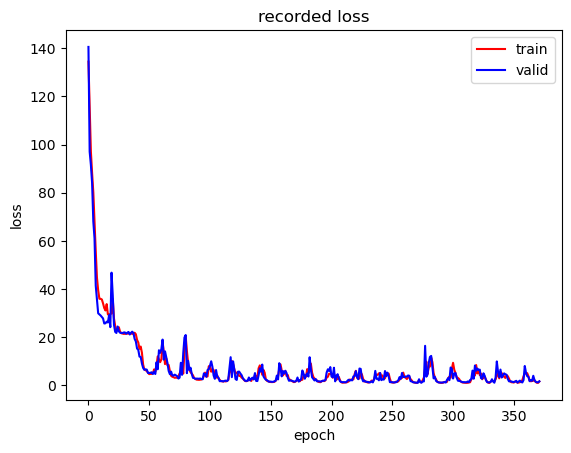

Fold 5
cuda is available
Early stopping
Training is end. Total trainig time: 0.3 minutes
Best validation loss: 0.7871979475021362


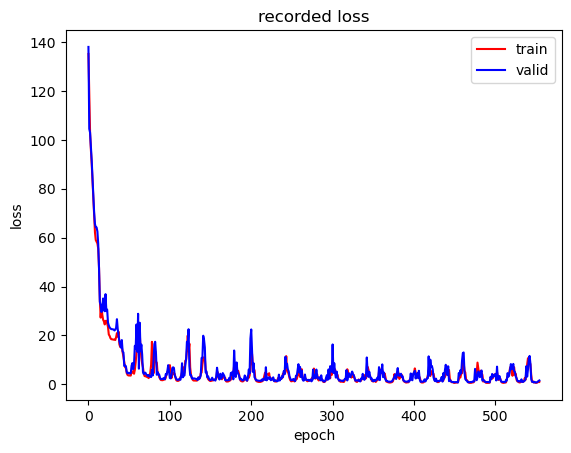

Averge RMSE performance: 0.8262108266353607
Tanh
Fold 1
cuda is available
Early stopping
Training is end. Total trainig time: 0.2 minutes
Best validation loss: 80.39946174621582


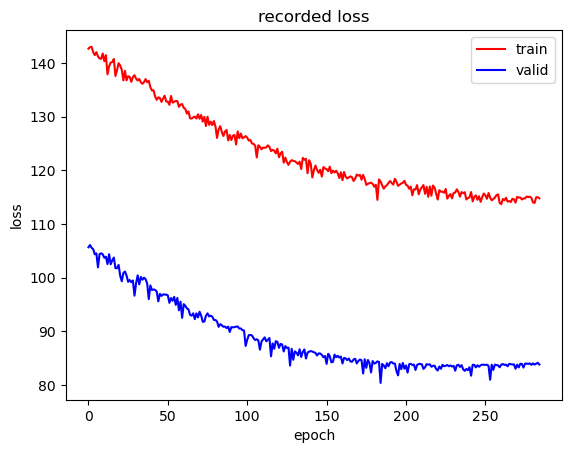

Fold 2
cuda is available
Early stopping
Training is end. Total trainig time: 0.2 minutes
Best validation loss: 120.77640533447266


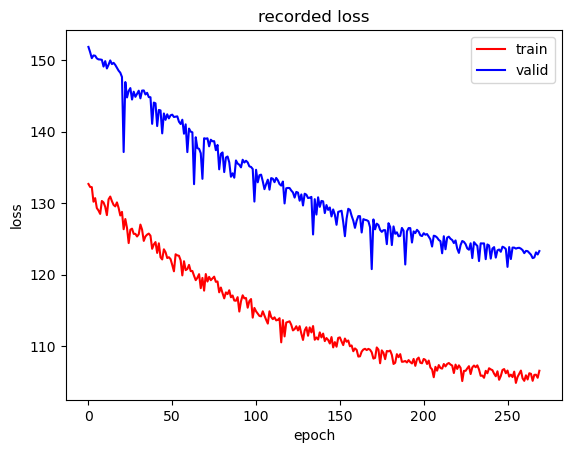

Fold 3
cuda is available
Early stopping
Training is end. Total trainig time: 0.3 minutes
Best validation loss: 107.09920883178711


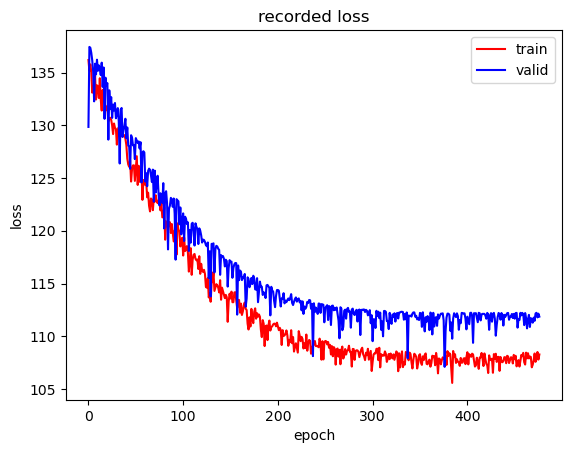

Fold 4
cuda is available
Training is end. Total trainig time: 0.6 minutes
Best validation loss: 30.319832801818848


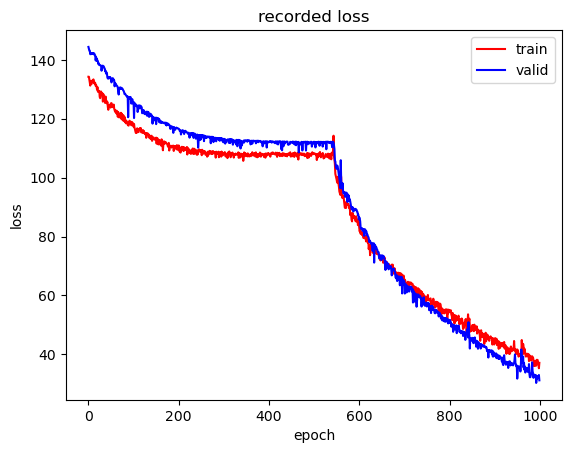

Fold 5
cuda is available
Early stopping
Training is end. Total trainig time: 0.2 minutes
Best validation loss: 108.53938674926758


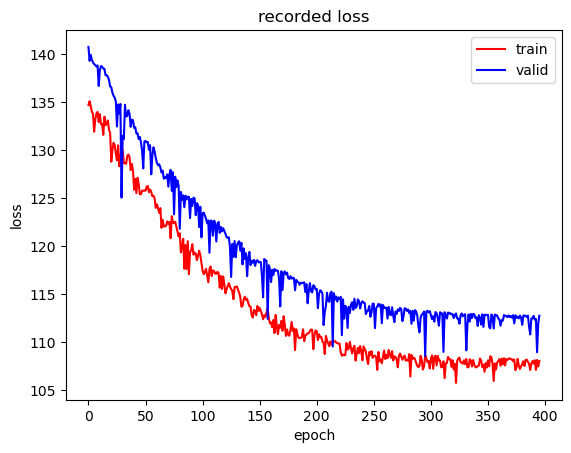

Averge RMSE performance: 89.4268590927124


In [9]:
# load dataset (先用較少的資料量避免訓練過久)
np.random.seed(0)
v0 = np.random.uniform(low=1, high=100, size=500) # 1-100
theta = np.random.uniform(low=1, high=90, size=500) # 1-90

# calculate true max_height, max_length (targets)
max_h = max_height(v0, theta) # 斜拋最大高度
max_l = max_length(v0, theta) # 斜拋最大距離

# concate data
x_data = np.concatenate((v0.reshape(-1, 1), theta.reshape(-1, 1)), axis=1)
y_data = np.concatenate((max_h.reshape(-1, 1), max_l.reshape(-1, 1)), axis=1)

# normalization
scaler_x = MinMaxScaler()
scaler_x.fit(x_data.reshape(-1, 2))
x_data = scaler_x.transform(x_data.reshape(-1, 2))

train_dataset = Projectile_Dataset(x_data, y_data, pred_target='max_height')
test_dataset = Projectile_Dataset(x_data, y_data, pred_target='max_height')

act_func_lst = ['ReLU', 'LeakyReLU', 'Sigmoid', 'Mish', 'Tanh']
avg_loss_lst = []

for activation_func in act_func_lst:
    # Kfold
    splits=KFold(n_splits=5, shuffle=True, random_state=100)
    kfold_history = {'model':[], 'train_idx':[], 'test_idx': [], 'train_min_loss':[], 'test_min_loss':[]}

    print(activation_func)
    for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(x_data.shape[0]))):
        print(f'Fold {fold+1}')

        # initiate data loader
        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(val_idx)
        train_loader = DataLoader(train_dataset, batch_size=50, sampler=train_sampler) # batch_size : 要分批餵入模型的資料大小
        test_loader = DataLoader(test_dataset, batch_size=50, sampler=test_sampler)

        # initiate model
        maxh_model = MaxH_DNN(activation_func=activation_func)

        # train
        saved_model, train_loss, valid_loss = train_model(maxh_model, train_loader, test_loader, num_epochs=1000, lr=1e-2, weight_decay=1e-6, T_max=10, eta_min=1e-6, patience=100)

        # draw loss plot
        loss_plot(train_loss, valid_loss)

        # save history
        kfold_history['model'].append(saved_model)
        kfold_history['train_idx'].append(train_idx)
        kfold_history['test_idx'].append(val_idx)
        kfold_history['train_min_loss'].append(np.min(train_loss))
        kfold_history['test_min_loss'].append(np.min(valid_loss))
    avg_rmse = np.mean(kfold_history['test_min_loss'])
    avg_loss_lst.append(avg_rmse)
    print('Averge RMSE performance: '+str(avg_rmse))

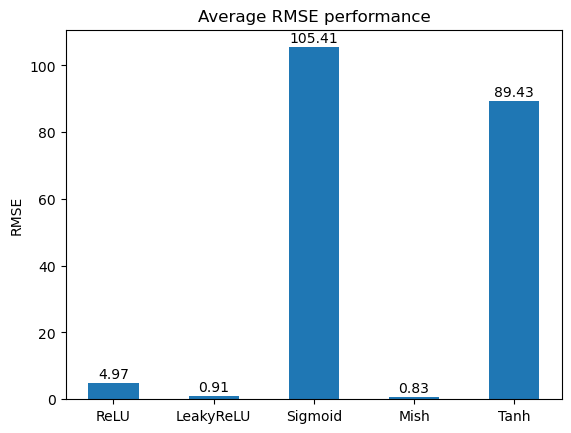

In [10]:
plt.figure()
plt.bar(act_func_lst, avg_loss_lst, width=0.5)
for a,b in zip(act_func_lst, avg_loss_lst):
    plt.text(a, b+0.5, '%.2f' % b, ha='center', va= 'bottom',fontsize=10)
plt.title('Average RMSE performance')
plt.ylabel('RMSE')
plt.show()

# 比較不同資料量

Size: 100
Fold 1
cuda is available
Early stopping
Training is end. Total trainig time: 0.1 minutes
Best validation loss: 1.9455419778823853


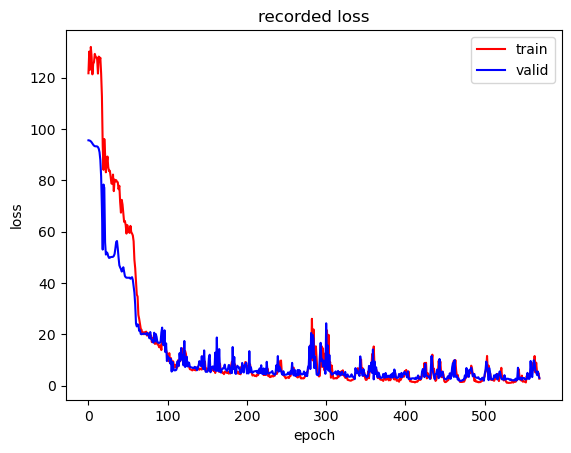

Fold 2
cuda is available
Early stopping
Training is end. Total trainig time: 0.1 minutes
Best validation loss: 2.820068359375


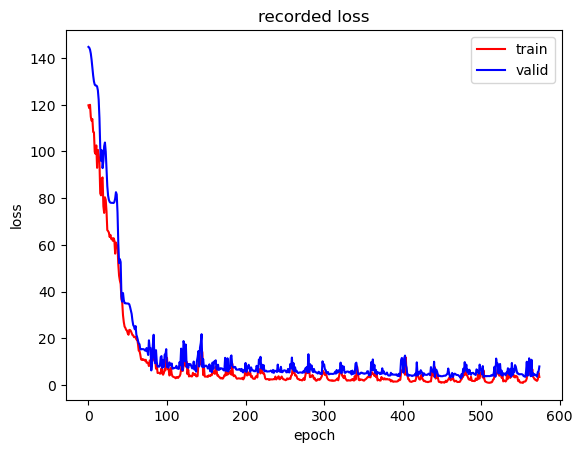

Fold 3
cuda is available
Early stopping
Training is end. Total trainig time: 0.0 minutes
Best validation loss: 5.878921985626221


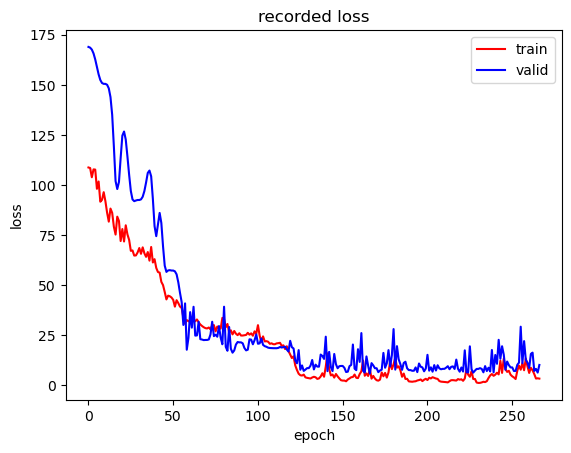

Fold 4
cuda is available
Early stopping
Training is end. Total trainig time: 0.1 minutes
Best validation loss: 2.113115072250366


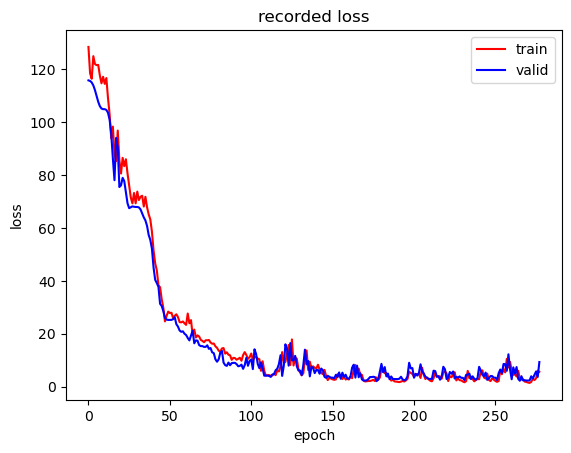

Fold 5
cuda is available
Early stopping
Training is end. Total trainig time: 0.1 minutes
Best validation loss: 4.981861591339111


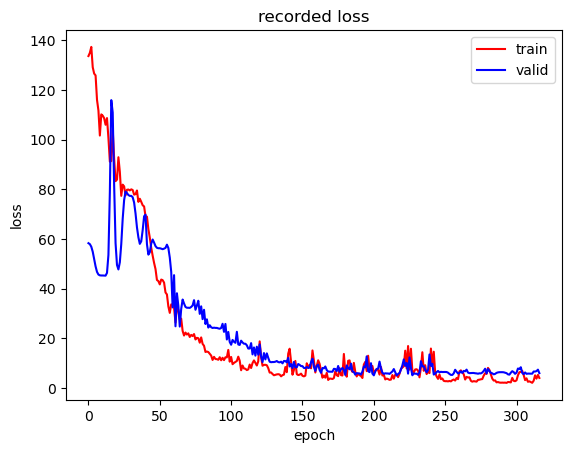

Averge RMSE performance: 3.5479017972946165
Size: 500
Fold 1
cuda is available
Early stopping
Training is end. Total trainig time: 0.2 minutes
Best validation loss: 0.7082941830158234


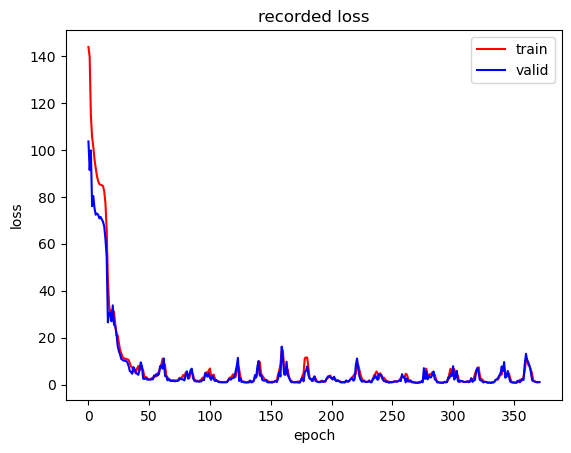

Fold 2
cuda is available
Early stopping
Training is end. Total trainig time: 0.2 minutes
Best validation loss: 1.0346489548683167


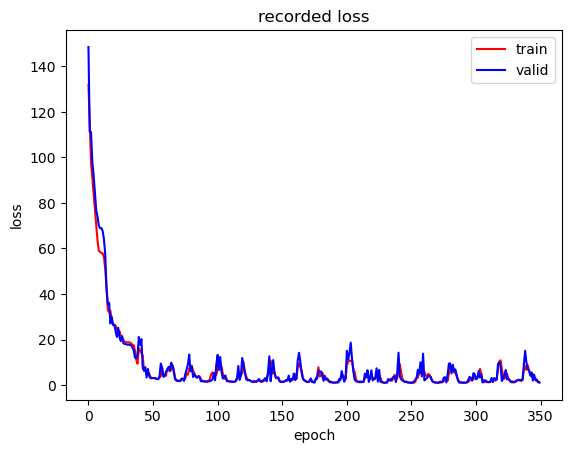

Fold 3
cuda is available
Early stopping
Training is end. Total trainig time: 0.3 minutes
Best validation loss: 0.8432087153196335


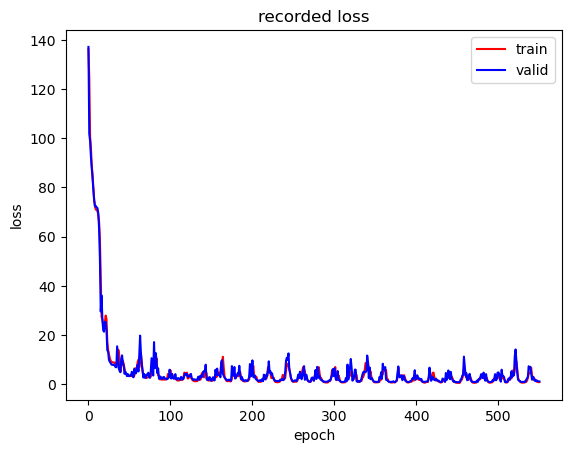

Fold 4
cuda is available
Early stopping
Training is end. Total trainig time: 0.3 minutes
Best validation loss: 0.9189538061618805


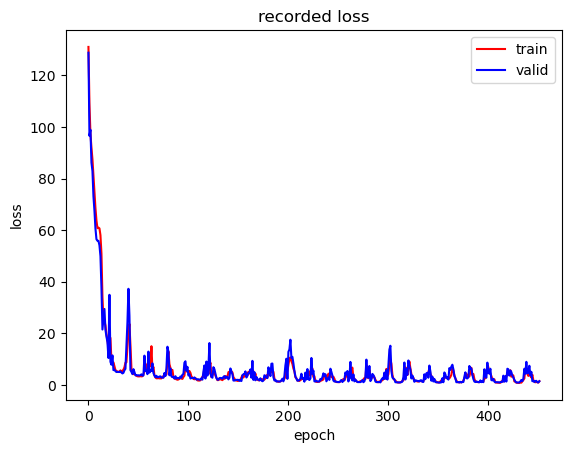

Fold 5
cuda is available
Early stopping
Training is end. Total trainig time: 0.3 minutes
Best validation loss: 1.1071528196334839


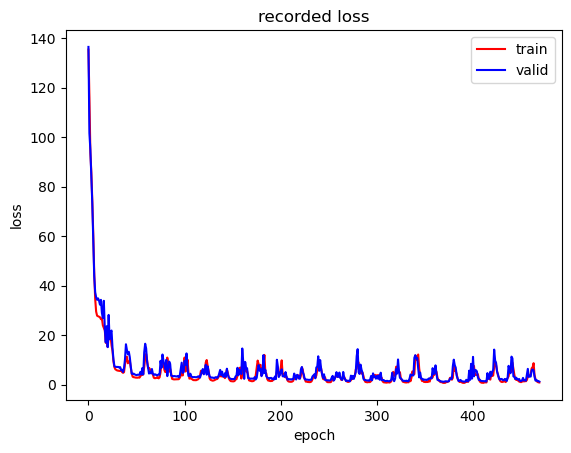

Averge RMSE performance: 0.9224516957998276
Size: 1000
Fold 1
cuda is available
Early stopping
Training is end. Total trainig time: 1.2 minutes
Best validation loss: 0.4084599018096924


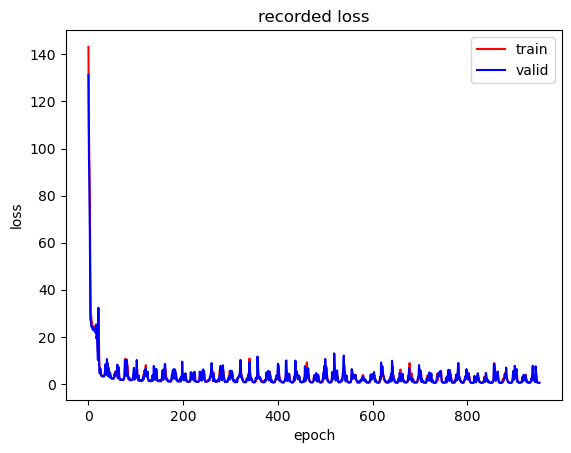

Fold 2
cuda is available
Early stopping
Training is end. Total trainig time: 0.8 minutes
Best validation loss: 0.5053461268544197


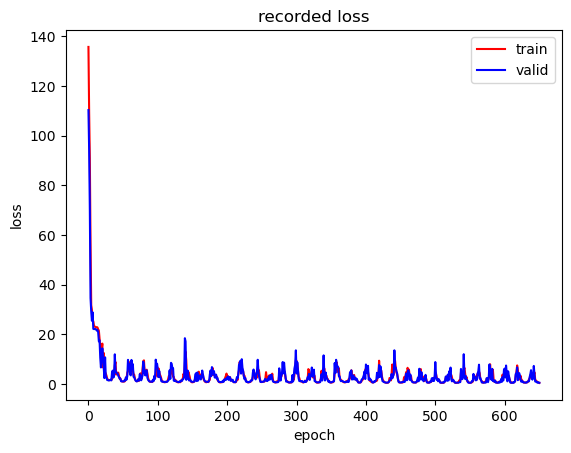

Fold 3
cuda is available
Early stopping
Training is end. Total trainig time: 0.8 minutes
Best validation loss: 0.5753679722547531


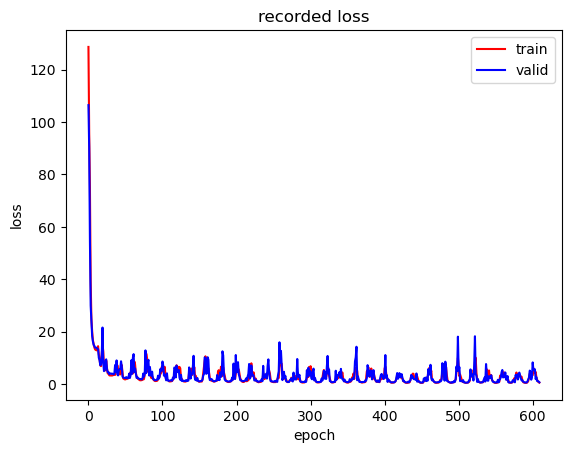

Fold 4
cuda is available
Early stopping
Training is end. Total trainig time: 1.0 minutes
Best validation loss: 0.521653801202774


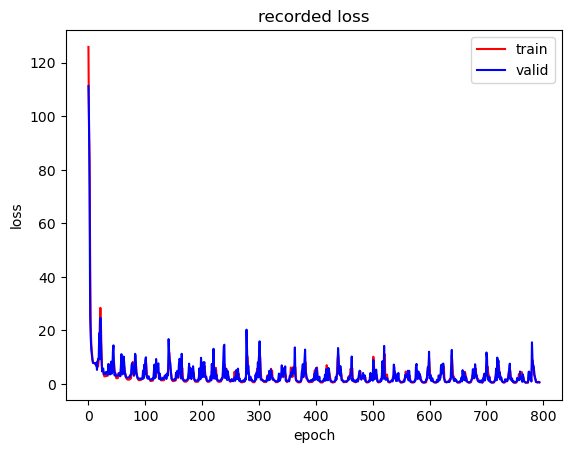

Fold 5
cuda is available
Early stopping
Training is end. Total trainig time: 0.6 minutes
Best validation loss: 0.5500066429376602


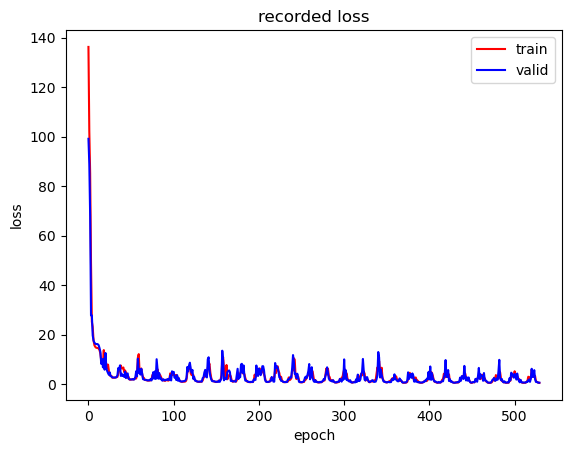

Averge RMSE performance: 0.5121668890118599
Size: 3000
Fold 1
cuda is available
Early stopping
Training is end. Total trainig time: 2.6 minutes
Best validation loss: 0.29726214831074077


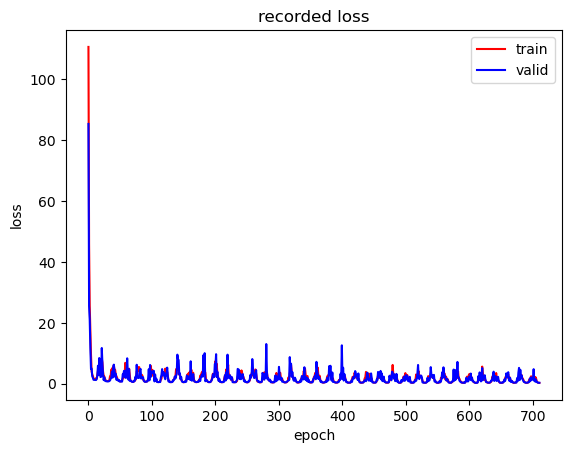

Fold 2
cuda is available
Early stopping
Training is end. Total trainig time: 1.1 minutes
Best validation loss: 0.47487154106299084


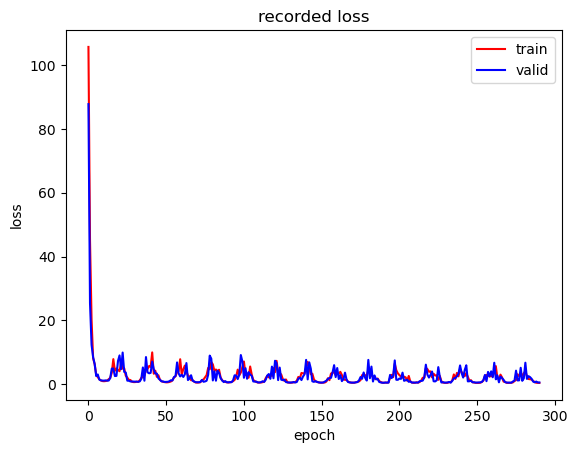

Fold 3
cuda is available
Early stopping
Training is end. Total trainig time: 1.2 minutes
Best validation loss: 0.47573304176330566


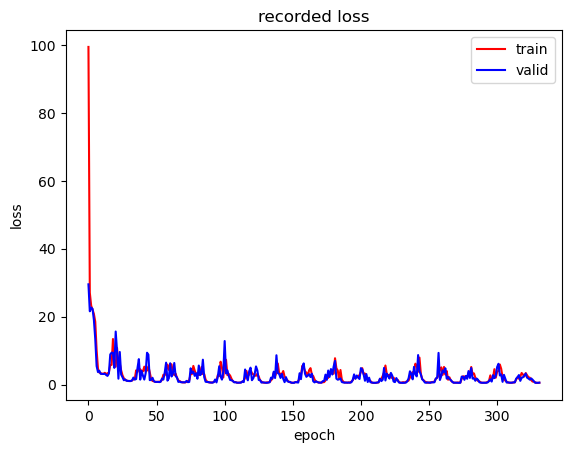

Fold 4
cuda is available
Early stopping
Training is end. Total trainig time: 2.8 minutes
Best validation loss: 0.28196433931589127


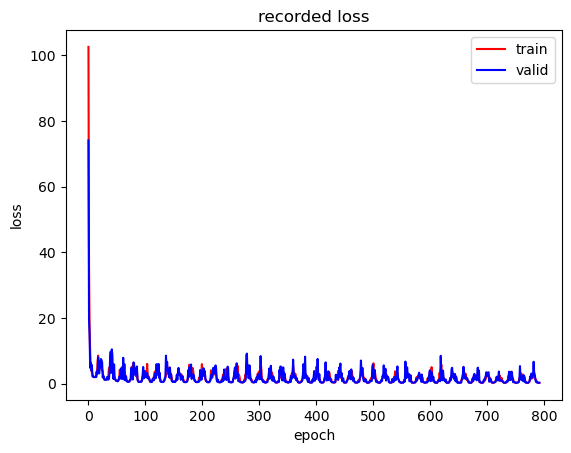

Fold 5
cuda is available
Early stopping
Training is end. Total trainig time: 2.6 minutes
Best validation loss: 0.2601594266792138


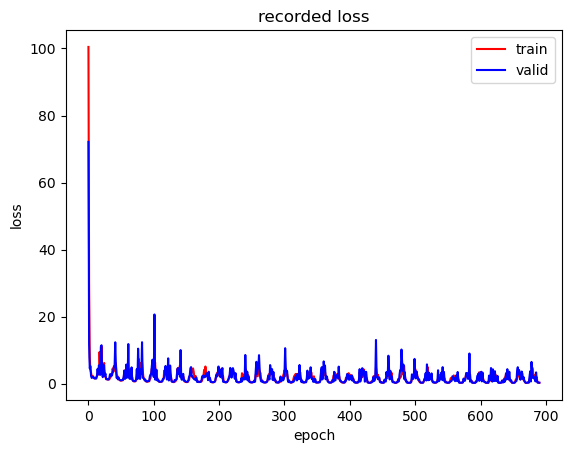

Averge RMSE performance: 0.35799809942642846
Size: 5000
Fold 1
cuda is available
Early stopping
Training is end. Total trainig time: 2.3 minutes
Best validation loss: 0.24465948045253755


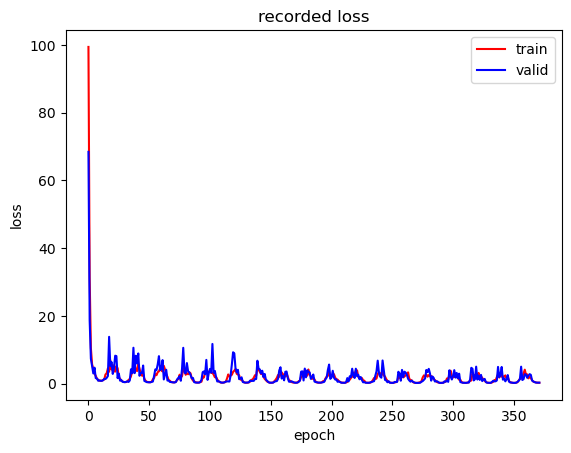

Fold 2
cuda is available
Early stopping
Training is end. Total trainig time: 3.1 minutes
Best validation loss: 0.2196274995803833


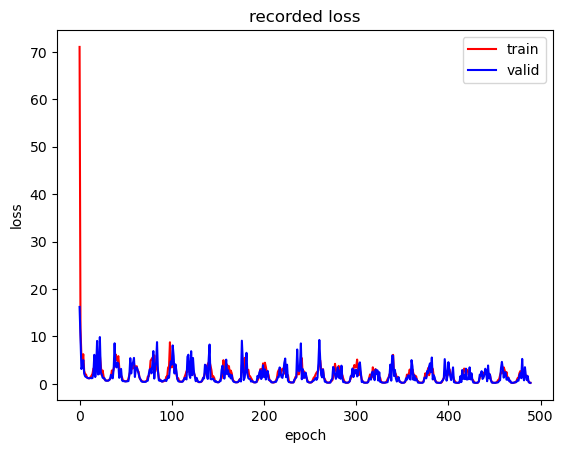

Fold 3
cuda is available
Early stopping
Training is end. Total trainig time: 4.1 minutes
Best validation loss: 0.2065848723053932


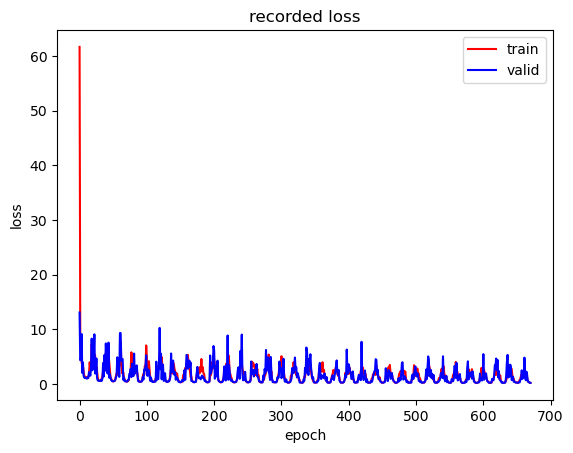

Fold 4
cuda is available
Early stopping
Training is end. Total trainig time: 4.2 minutes
Best validation loss: 0.21761242300271988


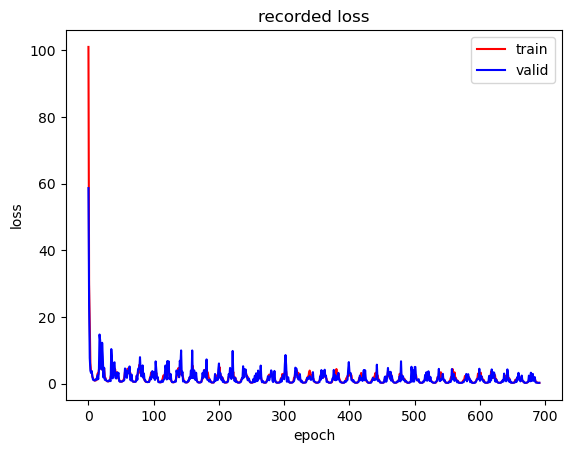

Fold 5
cuda is available
Early stopping
Training is end. Total trainig time: 3.8 minutes
Best validation loss: 0.21580502465367318


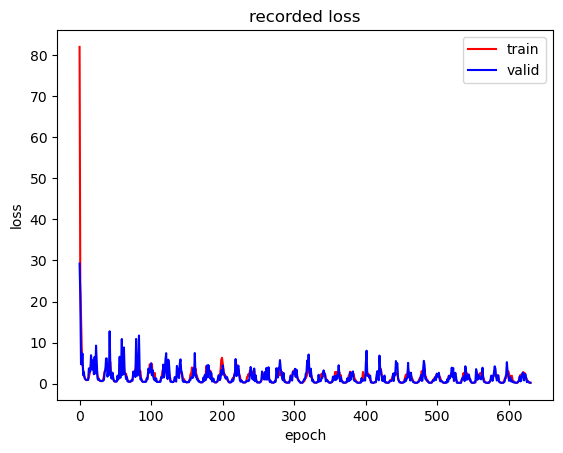

Averge RMSE performance: 0.22085785999894142


In [11]:
size_lst = [100, 500, 1000, 3000, 5000]
avg_loss_lst2 = []

for size in size_lst:
    # Kfold
    splits=KFold(n_splits=5, shuffle=True, random_state=100)
    kfold_history = {'model':[], 'train_idx':[], 'test_idx': [], 'train_min_loss':[], 'test_min_loss':[]}

    np.random.seed(0)
    v0 = np.random.uniform(low=1, high=100, size=size) # 1-100
    theta = np.random.uniform(low=1, high=90, size=size) # 1-90

    # calculate true max_height, max_length (targets)
    max_h = max_height(v0, theta) # 斜拋最大高度
    max_l = max_length(v0, theta) # 斜拋最大距離

    # concate data
    x_data = np.concatenate((v0.reshape(-1, 1), theta.reshape(-1, 1)), axis=1)
    y_data = np.concatenate((max_h.reshape(-1, 1), max_l.reshape(-1, 1)), axis=1)

    # normalization
    scaler_x = MinMaxScaler()
    scaler_x.fit(x_data.reshape(-1, 2))
    x_data = scaler_x.transform(x_data.reshape(-1, 2))

    # load dataset
    train_dataset = Projectile_Dataset(x_data, y_data, pred_target='max_height')
    test_dataset = Projectile_Dataset(x_data, y_data, pred_target='max_height')
    print('Size: '+str(size))

    for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(x_data.shape[0]))):
        print(f'Fold {fold+1}')

        # initiate data loader
        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(val_idx)
        train_loader = DataLoader(train_dataset, batch_size=50, sampler=train_sampler) # batch_size : 要分批餵入模型的資料大小
        test_loader = DataLoader(test_dataset, batch_size=50, sampler=test_sampler)

        # initiate model
        maxh_model = MaxH_DNN(activation_func='LeakyReLU')

        # train
        saved_model, train_loss, valid_loss = train_model(maxh_model, train_loader, test_loader, num_epochs=1000, lr=1e-2, weight_decay=1e-6, T_max=10, eta_min=1e-6, patience=100)

        # draw loss plot
        loss_plot(train_loss, valid_loss)

        # save history
        kfold_history['model'].append(saved_model)
        kfold_history['train_idx'].append(train_idx)
        kfold_history['test_idx'].append(val_idx)
        kfold_history['train_min_loss'].append(np.min(train_loss))
        kfold_history['test_min_loss'].append(np.min(valid_loss))
    avg_rmse = np.mean(kfold_history['test_min_loss'])
    avg_loss_lst2.append(avg_rmse)
    print('Averge RMSE performance: '+str(avg_rmse))


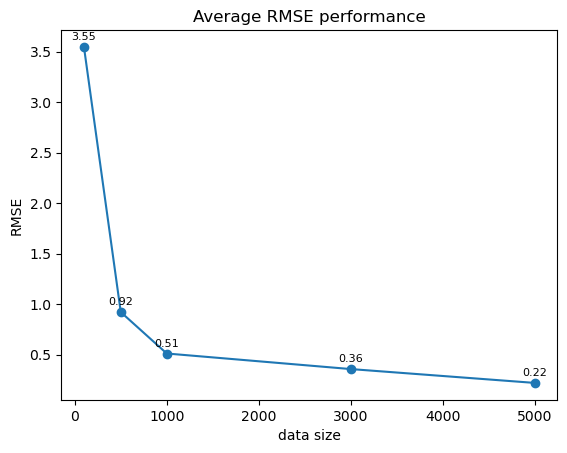

In [12]:
plt.figure()
plt.plot(size_lst, avg_loss_lst2, '-o')
for a,b in zip(size_lst, avg_loss_lst2):
    plt.text(a, b+0.05, '%.2f' % b, ha='center', va= 'bottom',fontsize=8)
plt.title('Average RMSE performance')
plt.ylabel('RMSE')
plt.xlabel('data size')
plt.show()

# 正式訓練使用 3000 筆資料 & Mish activation function

In [13]:
np.random.seed(0)
v0 = np.random.uniform(low=1, high=100, size=3000) # 1-100
theta = np.random.uniform(low=1, high=90, size=3000) # 1-90

# calculate true max_height, max_length (targets)
max_h = max_height(v0, theta) # 斜拋最大高度
max_l = max_length(v0, theta) # 斜拋最大距離

# concate data
X = np.concatenate((v0.reshape(-1, 1), theta.reshape(-1, 1)), axis=1)
Y = np.concatenate((max_h.reshape(-1, 1), max_l.reshape(-1, 1)), axis=1)

# normalization
scaler_x = MinMaxScaler()
scaler_x.fit(X.reshape(-1, 2))
X = scaler_x.transform(X.reshape(-1, 2))

# max_height train & evaluate

Fold 1
cuda is available
Early stopping
Training is end. Total trainig time: 2.4 minutes
Best validation loss: 0.09885092762609322


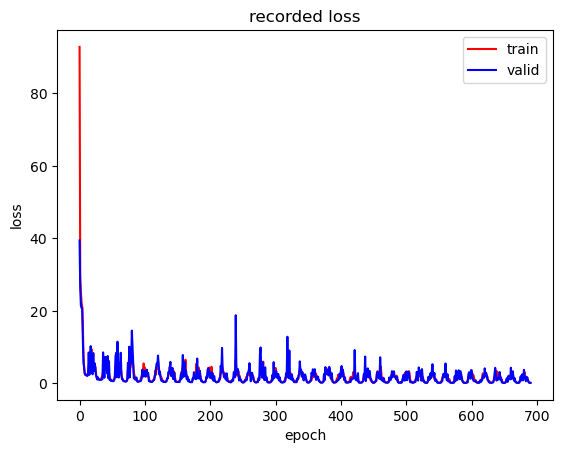

Fold 2
cuda is available
Early stopping
Training is end. Total trainig time: 2.5 minutes
Best validation loss: 0.19029478169977665


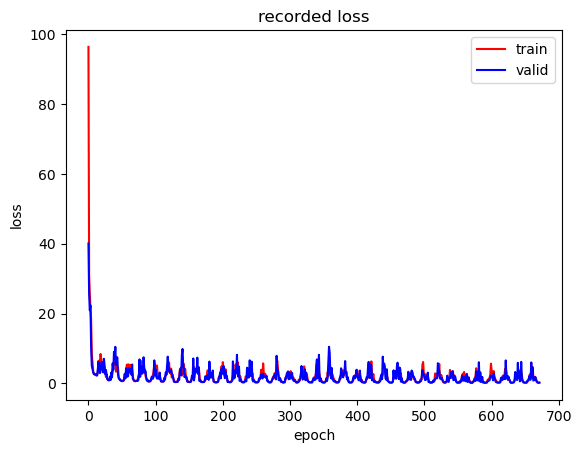

Fold 3
cuda is available
Early stopping
Training is end. Total trainig time: 2.9 minutes
Best validation loss: 0.10769168411691983


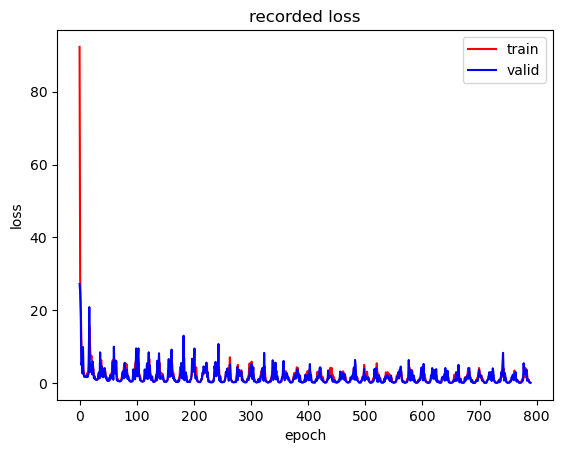

Fold 4
cuda is available
Early stopping
Training is end. Total trainig time: 3.0 minutes
Best validation loss: 0.12094198167324066


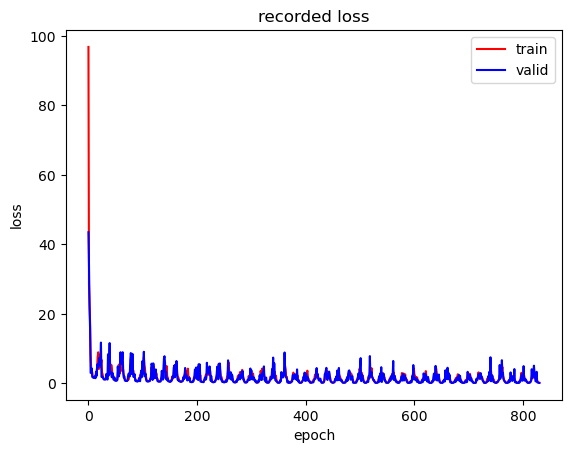

Fold 5
cuda is available
Early stopping
Training is end. Total trainig time: 1.5 minutes
Best validation loss: 0.18602202211817107


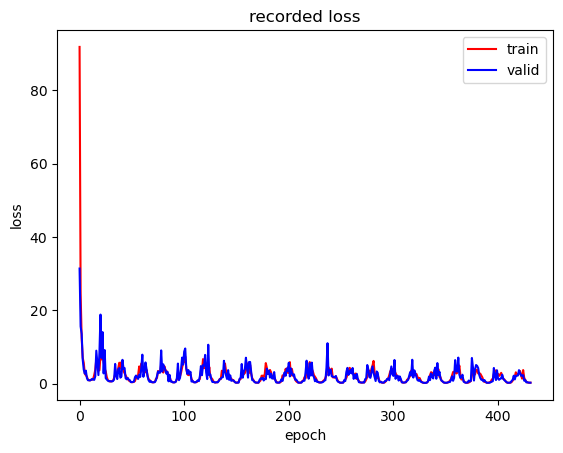

In [14]:
# Kfold
splits=KFold(n_splits=5, shuffle=True, random_state=100)
kfold_history = {'model':[], 'train_idx':[], 'test_idx': [], 'train_min_loss':[], 'test_min_loss':[]}

# load dataset
train_dataset = Projectile_Dataset(X, Y, pred_target='max_height')
test_dataset = Projectile_Dataset(X, Y, pred_target='max_height')

for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(X.shape[0]))):
    print(f'Fold {fold+1}')

    # initiate data loader
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train_dataset, batch_size=50, sampler=train_sampler) # batch_size : 要分批餵入模型的資料大小
    test_loader = DataLoader(test_dataset, batch_size=50, sampler=test_sampler)

    # initiate model
    maxh_model = MaxH_DNN(activation_func='Mish')

    # train
    saved_model, train_loss, valid_loss = train_model(maxh_model, train_loader, test_loader, num_epochs=1000, lr=1e-2, weight_decay=1e-6, T_max=10, eta_min=1e-6, patience=100)

    # draw loss plot
    loss_plot(train_loss, valid_loss)

    # save history
    kfold_history['model'].append(saved_model)
    kfold_history['train_idx'].append(train_idx)
    kfold_history['test_idx'].append(val_idx)
    kfold_history['train_min_loss'].append(np.min(train_loss))
    kfold_history['test_min_loss'].append(np.min(valid_loss))

## 5-fold cross-validation

Mean RMSE: 0.14076027944684028
Max RMSE: 0.19029478169977665
Min RMSE: 0.09885092762609322


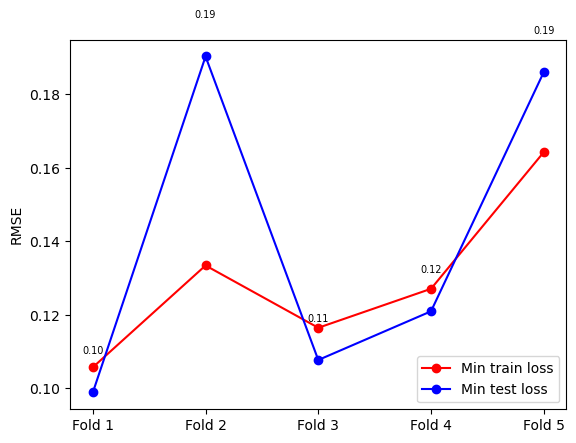

In [15]:
# 比較各fold的訓練結果
train_min_loss = kfold_history['train_min_loss']
test_min_loss = kfold_history['test_min_loss']
fold_num = ['Fold '+str(i+1) for i in range(5)]

print('Mean RMSE: '+str(np.mean(test_min_loss)))
print('Max RMSE: '+str(np.max(test_min_loss)))
print('Min RMSE: '+str(np.min(test_min_loss)))

plt.plot(fold_num, train_min_loss, 'ro-', label='Min train loss')
plt.plot(fold_num, test_min_loss, 'bo-', label='Min test loss')
for a,b in zip(fold_num, test_min_loss):
    plt.text(a, b+0.01, '%.2f' % b, ha='center', va= 'bottom',fontsize=7)
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
# 比較各fold的訓練結果
train_min_loss = kfold_history['train_min_loss']
test_min_loss = kfold_history['test_min_loss']
fold_num = ['Fold '+str(i+1) for i in range(5)]

print('Mean RMSE: '+str(np.mean(test_min_loss)))
print('Max RMSE: '+str(np.max(test_min_loss)))
print('Min RMSE: '+str(np.min(test_min_loss)))

plt.plot(fold_num, train_min_loss, 'ro-', label='Min train loss')
plt.plot(fold_num, test_min_loss, 'bo-', label='Min test loss')
for a,b in zip(fold_num, test_min_loss):
    plt.text(a, b+0.01, '%.2f' % b, ha='center', va= 'bottom',fontsize=7)
plt.ylabel('RMSE')
plt.legend()
plt.show()

cuda is available
Training set|RMSE: 0.12, R2: 0.9999988277753195
Testing set|RMSE: 0.10, R2: 0.9999992251396179


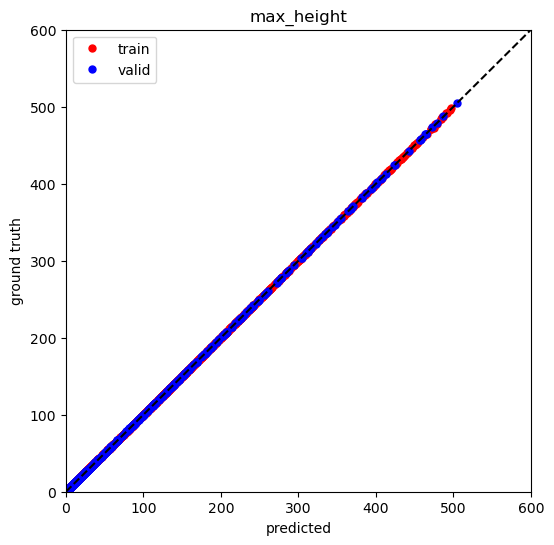

In [16]:
# 以test error最低的模型為最佳模型
best_result_idx = np.argmin(test_min_loss)

# 取得該模型的資料
best_maxh_model = kfold_history['model'][best_result_idx]
best_train_idx = kfold_history['train_idx'][best_result_idx]
best_test_idx = kfold_history['test_idx'][best_result_idx]

train_sampler = SubsetRandomSampler(best_train_idx)
test_sampler = SubsetRandomSampler(best_test_idx)
train_loader = DataLoader(train_dataset, batch_size=800, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=200, sampler=test_sampler)

test_true, test_pred = model_evaluate(best_maxh_model, train_loader, test_loader)

<AxesSubplot:xlabel='x', ylabel='y'>

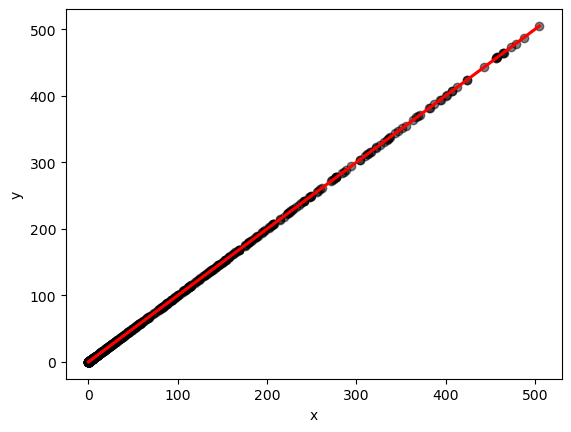

In [17]:
# 要畫信賴區間的圖但準確率太高看不出來
regplot_df = pd.DataFrame({'x': test_true, 'y': test_pred})
sns.regplot(x='x', y='y', data=regplot_df,
                          scatter_kws={'color':'black', 'alpha':0.5},
                          line_kws={'color':'red'},
                          ci=95)
# sns.lineplot(x='y', y='y', data=regplot_df, dashes=(2, 2))

## 3D plot

C:\Users\User\AppData\Local\Temp\ipykernel_23364\2737251523.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


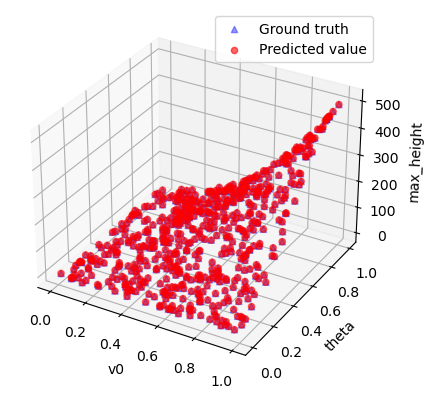

In [18]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x1, x2 = [], []
true, pred = [], []
with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        inputs = inputs
        targets = targets
        outputs = best_maxh_model.cpu()(inputs)
        
        x1.append(inputs[:,0].numpy())
        x2.append(inputs[:,1].numpy())
        true.append(targets.numpy())
        pred.append(outputs.numpy())

ax.scatter(x1, x2, true, marker='^', color='blue', label='Ground truth', alpha=0.4)
ax.scatter(x1, x2, pred, marker='o', color='red', label='Predicted value', alpha=0.6)
ax.legend()
ax.set_xlabel('v0')
ax.set_ylabel('theta')
ax.set_zlabel('max_height')
plt.show()

# max_length train & evaluate

Fold 1
cuda is available
Early stopping
Training is end. Total trainig time: 1.8 minutes
Best validation loss: 0.49018007268508273


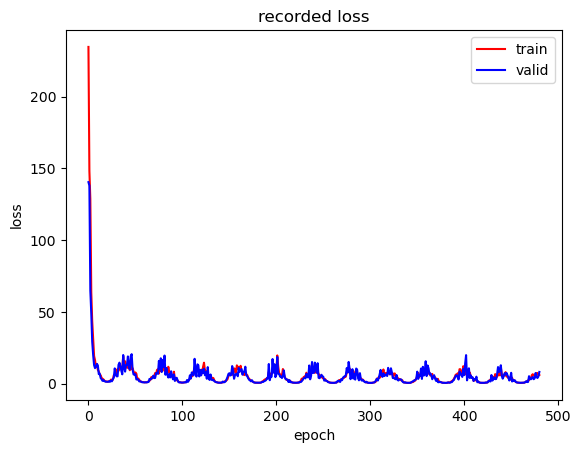

Fold 2
cuda is available
Early stopping
Training is end. Total trainig time: 2.8 minutes
Best validation loss: 0.49693191548188526


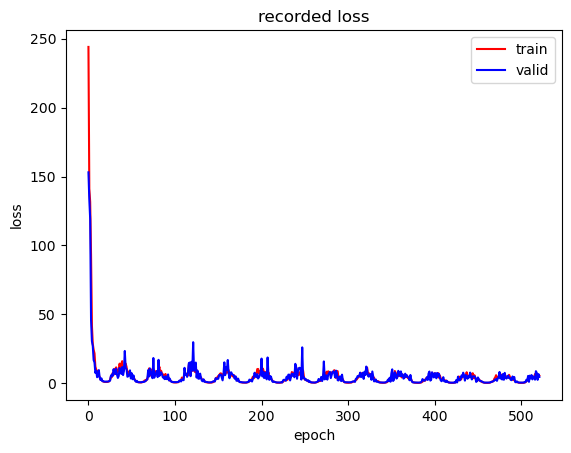

Fold 3
cuda is available
Early stopping
Training is end. Total trainig time: 2.9 minutes
Best validation loss: 0.3207543281217416


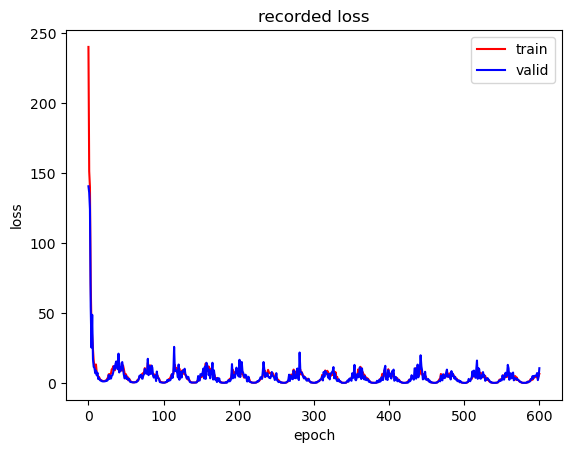

Fold 4
cuda is available
Early stopping
Training is end. Total trainig time: 2.3 minutes
Best validation loss: 0.5264568279186884


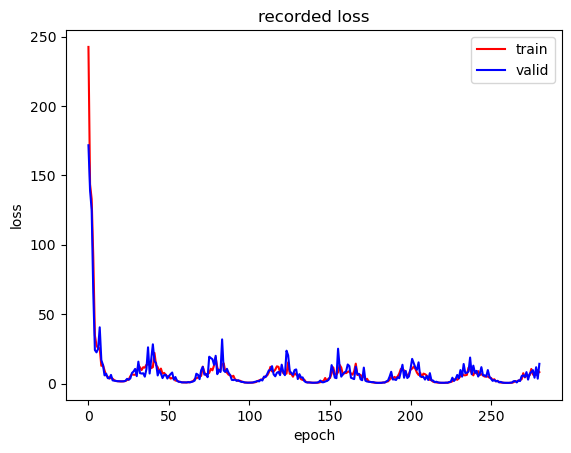

Fold 5
cuda is available
Early stopping
Training is end. Total trainig time: 3.1 minutes
Best validation loss: 0.3501945932706197


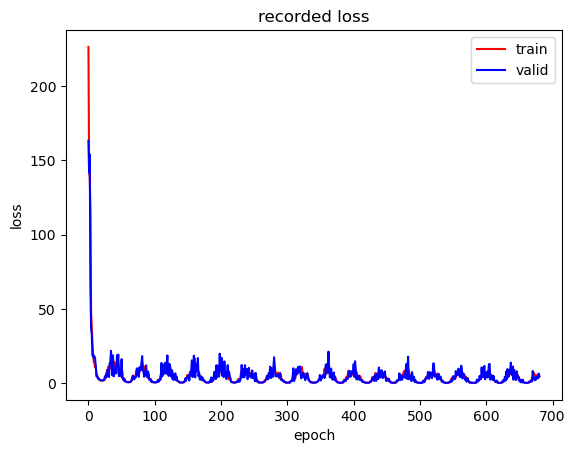

In [19]:
# Kfold
splits=KFold(n_splits=5, shuffle=True, random_state=100)
kfold_history_L = {'model':[], 'train_idx':[], 'test_idx': [], 'train_min_loss':[], 'test_min_loss':[]}

# load dataset
train_dataset_L = Projectile_Dataset(X, Y, pred_target='max_length')
test_dataset_L = Projectile_Dataset(X, Y, pred_target='max_length')

for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(X.shape[0]))):
    print(f'Fold {fold+1}')

    # initiate data loader
    train_sampler_L = SubsetRandomSampler(train_idx)
    test_sampler_L = SubsetRandomSampler(val_idx)
    train_loader_L = DataLoader(train_dataset_L, batch_size=50, sampler=train_sampler_L) # batch_size : 要分批餵入模型的資料大小
    test_loader_L = DataLoader(test_dataset_L, batch_size=50, sampler=test_sampler_L)

    # initiate model
    maxl_model = MaxL_DNN(activation_func='Mish')

    saved_model_L, train_loss_L, valid_loss_L = train_model(maxl_model, train_loader_L, test_loader_L, num_epochs=1000, lr=5*1e-3, weight_decay=1e-6, T_max=20, eta_min=1e-6, patience=100)

    # draw loss plot
    loss_plot(train_loss_L, valid_loss_L)

    # save history
    kfold_history_L['model'].append(saved_model_L)
    kfold_history_L['train_idx'].append(train_idx)
    kfold_history_L['test_idx'].append(val_idx)
    kfold_history_L['train_min_loss'].append(np.min(train_loss_L))
    kfold_history_L['test_min_loss'].append(np.min(valid_loss_L))

# 5-fold cross-validation

Mean RMSE: 0.43690354749560356
Max RMSE: 0.5264568279186884
Min RMSE: 0.3207543281217416


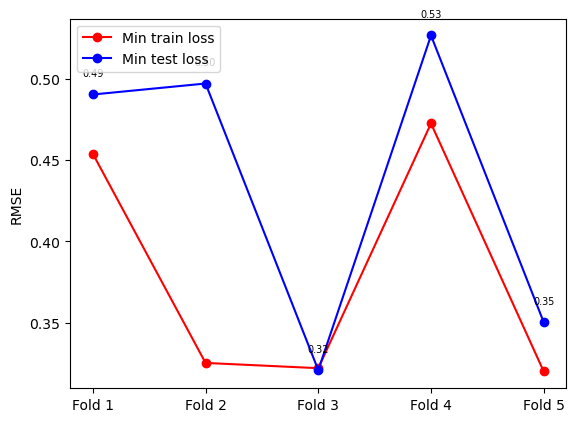

In [20]:
# 比較各fold的訓練結果
train_min_loss = kfold_history_L['train_min_loss']
test_min_loss = kfold_history_L['test_min_loss']
fold_num = ['Fold '+str(i+1) for i in range(5)]

print('Mean RMSE: '+str(np.mean(test_min_loss)))
print('Max RMSE: '+str(np.max(test_min_loss)))
print('Min RMSE: '+str(np.min(test_min_loss)))

plt.plot(fold_num, train_min_loss, 'ro-', label='Min train loss')
plt.plot(fold_num, test_min_loss, 'bo-', label='Min test loss')
for a,b in zip(fold_num, test_min_loss):
    plt.text(a, b+0.01, '%.2f' % b, ha='center', va= 'bottom',fontsize=7)
plt.ylabel('RMSE')
plt.legend()
plt.show()

cuda is available
Training set|RMSE: 0.33, R2: 0.9999981721242269
Testing set|RMSE: 0.33, R2: 0.9999980529149374


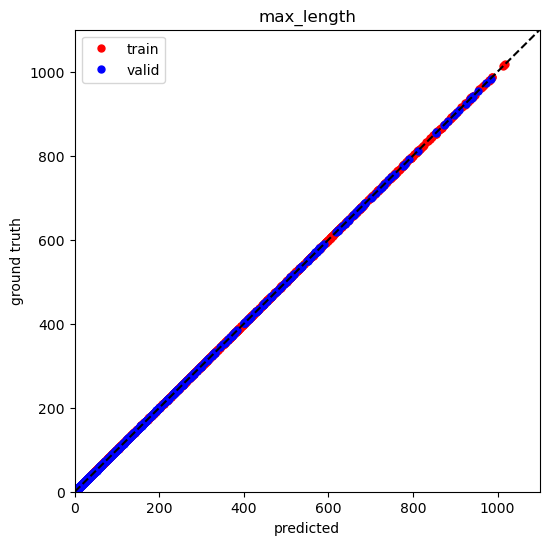

In [21]:
# 以test error最低的模型為最佳模型
best_result_idx = np.argmin(test_min_loss)

# 取得該模型的資料
best_maxl_model = kfold_history_L['model'][best_result_idx]
best_train_idx = kfold_history_L['train_idx'][best_result_idx]
best_test_idx = kfold_history_L['test_idx'][best_result_idx]

train_sampler_L = SubsetRandomSampler(best_train_idx)
test_sampler_L = SubsetRandomSampler(best_test_idx)
train_loader_L = DataLoader(train_dataset_L, batch_size=800, sampler=train_sampler_L)
test_loader_L = DataLoader(test_dataset_L, batch_size=200, sampler=test_sampler_L)

test_true_L, test_pred_L = model_evaluate(best_maxl_model, train_loader_L, test_loader_L, pred_target='max_length')

<AxesSubplot:xlabel='x', ylabel='y'>

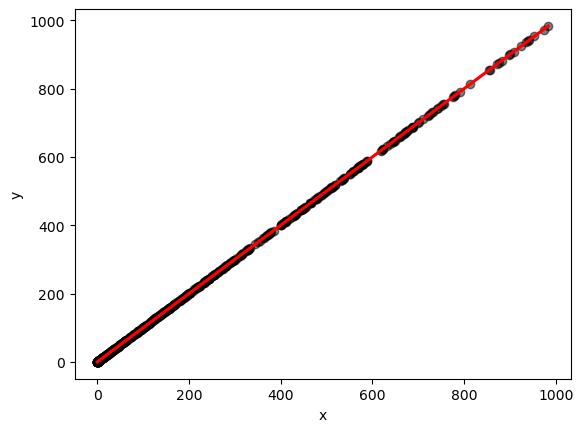

In [22]:
# 要畫信賴區間的圖但準確率太高看不出來
regplot_df = pd.DataFrame({'x': test_true_L, 'y': test_pred_L})
sns.regplot(x='x', y='y', data=regplot_df,
                          scatter_kws={'color':'black', 'alpha':0.5},
                          line_kws={'color':'red'},
                          ci=95)

## 3D plot

C:\Users\User\AppData\Local\Temp\ipykernel_23364\3363949204.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


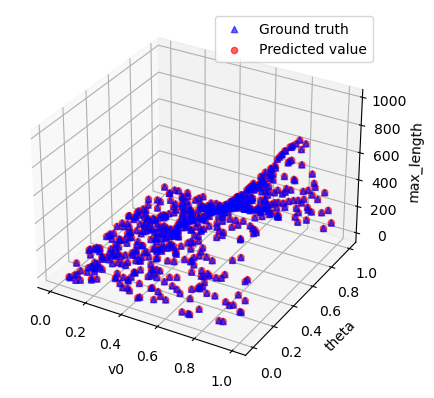

In [23]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x1, x2 = [], []
true, pred = [], []
with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader_L):
        inputs = inputs
        targets = targets
        outputs = best_maxl_model.cpu()(inputs)
        
        x1.append(inputs[:,0].numpy())
        x2.append(inputs[:,1].numpy())
        true.append(targets.numpy())
        pred.append(outputs.numpy())

ax.scatter(x1, x2, true, marker='^', color='blue', label='Ground truth', alpha=0.6)
ax.scatter(x1, x2, pred, marker='o', color='red', label='Predicted value', alpha=0.6)
ax.legend()
ax.set_xlabel('v0')
ax.set_ylabel('theta')
ax.set_zlabel('max_length')
plt.show()

# 補充：奇數角度訓練 偶數角度預測

In [57]:
np.random.seed(0)
v0 = np.random.uniform(low=1, high=100, size=5000) # 1-100
# 產生1到90之間的所有偶數
even_numbers = np.arange(2, 90, 2)

# 從偶數中隨機選擇一個數字
theta_even = np.random.choice(even_numbers, size=5000)

def max_height(v0, theta):
    theta = theta*np.pi/180 # 換算為弧度
    h = (v0**2) * np.sin(theta)**2 / (2*9.8)
    return h

def max_length(v0, theta):
    theta = theta*np.pi/180
    l = (v0**2) * np.sin(2*theta) / 9.8
    return l

# calculate true max_height, max_length (targets)
max_h = max_height(v0, theta_even) # 斜拋最大高度
max_l = max_length(v0, theta_even) # 斜拋最大距離

print('The largest value of max_height: ', + np.max(max_h))
print('The largest value of max_length: ', + np.max(max_l))


The largest value of max_height:  505.26103179775663
The largest value of max_length:  1018.3292208668


In [58]:
from sklearn.preprocessing import MinMaxScaler

# concate data
X_even = np.concatenate((v0.reshape(-1, 1), theta_even.reshape(-1, 1)), axis=1)
Y_even = np.concatenate((max_h.reshape(-1, 1), max_l.reshape(-1, 1)), axis=1)

# normalization
scaler_x = MinMaxScaler()
scaler_x.fit(X_even.reshape(-1, 2))
X_even = scaler_x.transform(X_even.reshape(-1, 2))

# load dataset
even_dataset = Projectile_Dataset(X_even, Y_even, pred_target='max_height')

In [59]:
np.random.seed(1)
v0 = np.random.uniform(low=1, high=100, size=5000) # 1-100
# 產生1到90之間的所有奇數
odd_numbers = np.arange(1, 91, 2)
theta_odd = np.random.choice(odd_numbers, size=5000)

# calculate true max_height, max_length (targets)
max_h = max_height(v0, theta_odd) # 斜拋最大高度
max_l = max_length(v0, theta_odd) # 斜拋最大距離

# concate data
X_odd = np.concatenate((v0.reshape(-1, 1), theta_odd.reshape(-1, 1)), axis=1)
Y_odd = np.concatenate((max_h.reshape(-1, 1), max_l.reshape(-1, 1)), axis=1)

# normalization
scaler_x = MinMaxScaler()
scaler_x.fit(X_odd.reshape(-1, 2))
X_odd = scaler_x.transform(X_odd.reshape(-1, 2))

# load dataset
odd_dataset = Projectile_Dataset(X_odd, Y_odd, pred_target='max_height')

cuda is available
[Epoch 1/1000] train_loss: 140.41, valid_loss: 139.50
[Epoch 2/1000] train_loss: 137.91, valid_loss: 131.94
[Epoch 3/1000] train_loss: 122.49, valid_loss: 103.74
[Epoch 4/1000] train_loss: 103.87, valid_loss: 99.12
[Epoch 5/1000] train_loss: 97.82, valid_loss: 94.49
[Epoch 6/1000] train_loss: 92.42, valid_loss: 89.47
[Epoch 7/1000] train_loss: 87.51, valid_loss: 84.69
[Epoch 8/1000] train_loss: 83.70, valid_loss: 81.74
[Epoch 9/1000] train_loss: 81.18, valid_loss: 80.05
[Epoch 10/1000] train_loss: 79.98, valid_loss: 79.61
[Epoch 11/1000] train_loss: 79.70, valid_loss: 79.61
[Epoch 12/1000] train_loss: 79.52, valid_loss: 79.14
[Epoch 13/1000] train_loss: 78.48, valid_loss: 77.18
[Epoch 14/1000] train_loss: 75.47, valid_loss: 72.34
[Epoch 15/1000] train_loss: 68.51, valid_loss: 61.31
[Epoch 16/1000] train_loss: 52.91, valid_loss: 37.81
[Epoch 17/1000] train_loss: 32.07, valid_loss: 29.33
[Epoch 18/1000] train_loss: 34.38, valid_loss: 35.47
[Epoch 19/1000] train_loss: 31

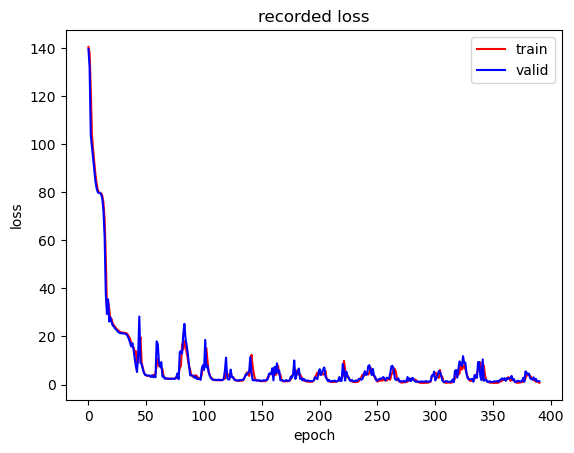

In [60]:
train_loader = DataLoader(odd_dataset, batch_size=1000) # batch_size : 要分批餵入模型的資料大小
test_loader = DataLoader(even_dataset, batch_size=1000)

# initiate model
maxh_model = MaxH_DNN(activation_func='Mish')

# train
saved_model, train_loss, valid_loss = train_model(maxh_model, train_loader, test_loader, num_epochs=1000, lr=1e-2, weight_decay=1e-6, T_max=10, eta_min=1e-6, patience=100)

# draw loss plot
loss_plot(train_loss, valid_loss)

In [61]:
def model_evaluate_new(model, odd_loader, even_loader, pred_target='max_height'):
    """
    Using RMSE & r2 score as metrics
    """
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('cuda is available')

    model = model.to(device).eval() # evaluation mode
    train_rmse_lst = []
    test_rmse_lst = []
    train_mape_lst = []
    test_mape_lst = []
    train_true_lst, train_pred_lst = [], []
    test_true_lst, test_pred_lst = [], []

    if pred_target == 'max_height':
        xlim, ylim = 0, 600
    elif pred_target == 'max_length':
        xlim, ylim = 0, 1100

    fig, ax = plt.subplots(figsize=(6, 6))
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(odd_loader):
            inputs = inputs.to(device)
            targets = targets
            outputs = model(inputs)

            mape_train = r2_score(outputs.view(-1), targets.view(-1).cuda())
            rmse_train = mean_squared_error(outputs.view(-1), targets.view(-1).cuda(), squared=False)
            
            train_rmse_lst.append(rmse_train.item())
            train_mape_lst.append(mape_train.item())
            train_true_lst.append(targets.tolist())
            train_pred_lst.append(outputs.tolist())

            # plot
            if i == 0:
                ax.plot(outputs.cpu(), targets, 'ro', markersize=5, label='odd')
            else:
                ax.plot(outputs.cpu(), targets, 'ro', markersize=5)
        
        print(f'Training set|RMSE: {np.average(train_rmse_lst):.2f}, R2: {np.average(train_mape_lst)}')

        for i, (inputs, targets) in enumerate(even_loader):
            inputs = inputs.to(device)
            targets = targets
            outputs = model(inputs)
            
            mape_test = r2_score(outputs.view(-1), targets.view(-1).cuda())
            rmse_test = mean_squared_error(outputs.view(-1), targets.view(-1).cuda(), squared=False)
            
            test_rmse_lst.append(rmse_test.item())
            test_mape_lst.append(mape_test.item())
            test_true_lst.append(targets.tolist())
            test_pred_lst.append(outputs.tolist())

            # plot
            if i == 0:
                ax.plot(outputs.cpu(), targets, 'bo', markersize=5, label='even')
            else:
                ax.plot(outputs.cpu(), targets, 'bo', markersize=5)

        print(f'Testing set|RMSE: {np.average(test_rmse_lst):.2f}, R2: {np.average(test_mape_lst)}')

        ax.set_title(pred_target)
        ax.set_xlim(xlim, ylim)
        ax.set_ylim(xlim, ylim)
        ax.plot([xlim, ylim], [xlim, ylim], 'k--', linewidth=1.5)
        ax.set_xlabel('predicted')
        ax.set_ylabel('ground truth')
        ax.legend()
        plt.savefig('Figures/'+pred_target+'.png')
        plt.show()
    
    return np.ravel(test_true_lst), np.ravel(test_pred_lst)

cuda is available
Training set|RMSE: 0.68, R2: 0.9999626636505127
Testing set|RMSE: 1.19, R2: 0.9998836874961853


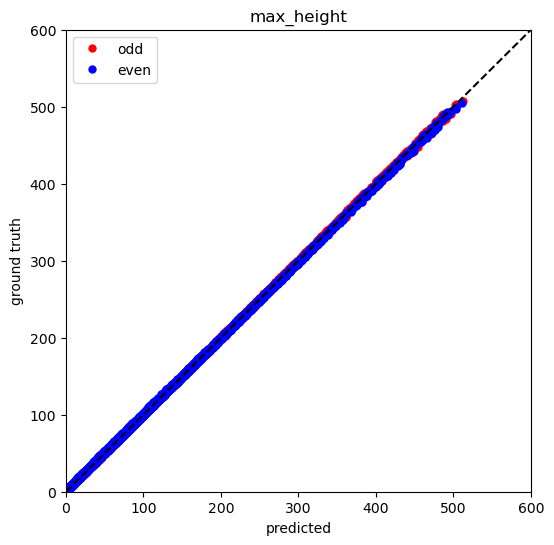

In [62]:
test_true, test_pred = model_evaluate_new(maxh_model, train_loader, test_loader)

cuda is available
[Epoch 1/1000] train_loss: 320.73, valid_loss: 318.10
[Epoch 2/1000] train_loss: 272.74, valid_loss: 252.93
[Epoch 3/1000] train_loss: 227.73, valid_loss: 228.46
[Epoch 4/1000] train_loss: 207.87, valid_loss: 196.44
[Epoch 5/1000] train_loss: 186.47, valid_loss: 178.35
[Epoch 6/1000] train_loss: 168.55, valid_loss: 152.35
[Epoch 7/1000] train_loss: 152.21, valid_loss: 141.79
[Epoch 8/1000] train_loss: 144.34, valid_loss: 138.19
[Epoch 9/1000] train_loss: 141.33, valid_loss: 135.41
[Epoch 10/1000] train_loss: 140.51, valid_loss: 135.10
[Epoch 11/1000] train_loss: 140.39, valid_loss: 135.10
[Epoch 12/1000] train_loss: 140.26, valid_loss: 135.08
[Epoch 13/1000] train_loss: 139.91, valid_loss: 135.17
[Epoch 14/1000] train_loss: 139.17, valid_loss: 133.04
[Epoch 15/1000] train_loss: 138.31, valid_loss: 132.83
[Epoch 16/1000] train_loss: 137.82, valid_loss: 131.62
[Epoch 17/1000] train_loss: 136.94, valid_loss: 130.00
[Epoch 18/1000] train_loss: 135.39, valid_loss: 129.06
[

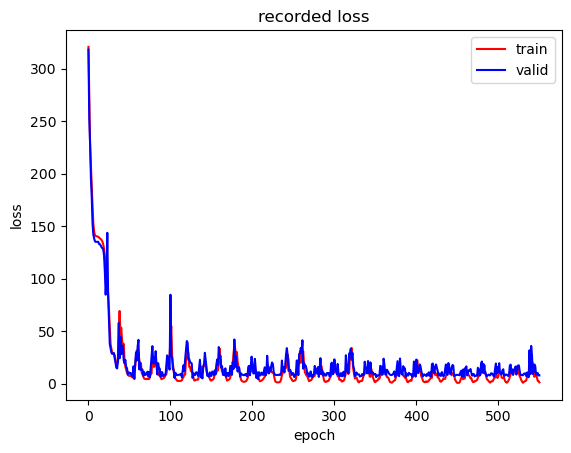

In [63]:
even_dataset = Projectile_Dataset(X_even, Y_even, pred_target='max_length')
odd_dataset = Projectile_Dataset(X_odd, Y_odd, pred_target='max_length')

train_loader = DataLoader(odd_dataset, batch_size=1000) # batch_size : 要分批餵入模型的資料大小
test_loader = DataLoader(even_dataset, batch_size=1000)


# initiate model
maxl_model = MaxL_DNN(activation_func='Mish')

# train
saved_model, train_loss, valid_loss = train_model(maxl_model, train_loader, test_loader, num_epochs=1000, lr=1e-2, weight_decay=1e-6, T_max=10, eta_min=1e-6, patience=100)

# draw loss plot
loss_plot(train_loss, valid_loss)

cuda is available
Training set|RMSE: 0.78, R2: 0.9999892234802246
Testing set|RMSE: 8.44, R2: 0.9987674117088318


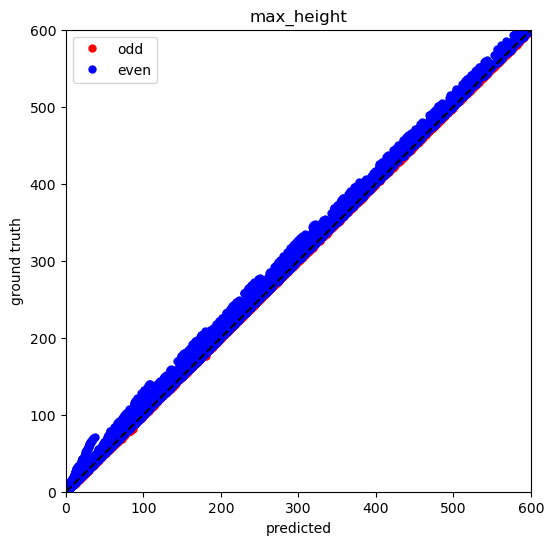

In [64]:
test_true, test_pred = model_evaluate_new(maxl_model, train_loader, test_loader)

In [24]:
# 產生資料 模型(層數設計, activation function, loss function, metrics) 訓練結果(視覺化圖, n-fold)